# 3. Spatial and spectral matching between photometric data cube and IFS data cube -- I. Spatial matching 

<font size="4"> In this step, we will match spatially on pixel level the reduced photometric data cube (produced from the previous step) and the IFS data cube from the CALIFA survey. This task can be performed using `piXedfit.piXedfit_spectrophotometric.match_imgifs_spatial` function. CALIFA data cube can be downloaded from this __[link](https://califa.caha.es/?q=content/califa-3rd-data-release)__ . For the CALIFA data cubes, on the COMB data format can be analyzed with the current version of piXedfit.</font>

In [1]:
import numpy as np
from astropy.io import fits
import os, sys
import matplotlib.pyplot as plt

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME)

%matplotlib inline

In [2]:
from piXedfit.piXedfit_spectrophotometric import match_imgifs_spatial

## 3.1. Spatial matching between multiband imaging data and IFS data

In [3]:
photo_fluxmap = "fluxmap_ngc309.fits"              # photometric data cube
ifs_data = "NGC0309.COMB.rscube.fits.gz"           # IFS data cube
ifs_survey = "califa"                              # IFS survey
nproc = 10                                         # Number of processor
name_out_fits = "specphoto_fluxmap_ngc309.fits"    # Desired output name
match_imgifs_spatial(photo_fluxmap, ifs_data, ifs_survey=ifs_survey, nproc=nproc, name_out_fits=name_out_fits)

## 3.2. Check the result: spectrophotometric data cube

In [4]:
cube = fits.open("specphoto_fluxmap_ngc309.fits")
cube.info()
print (cube[0].header)

Filename: specphoto_fluxmap_ngc309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PHOTO_FLUX    1 PrimaryHDU      35   (131, 131, 12)   float64   
  1  PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  2  WAVE          1 ImageHDU         7   (1901,)   float64   
  3  SPEC_FLUX     1 ImageHDU         9   (131, 131, 1901)   float64   
  4  SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1901)   float64   
  5  SPEC_REGION    1 ImageHDU         8   (131, 131)   float64   
  6  PHOTO_REGION    1 ImageHDU         8   (131, 131)   float64   
  7  STAMP_IMAGE    1 ImageHDU       107   (131, 131)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  131                                                  NAXIS2  =               

In [5]:
# get header
header = cube[0].header

# get photometry and IFS regions
photo_region = cube['photo_region'].data
spec_region = cube['spec_region'].data 

# get unit of flux
unit_flux = float(header['unit'])         # in erg/s/cm2/A

# get maps of photometric fluxes
map_fluxes = cube['photo_flux'].data

# get photometric SEDs of individual pixels
# transpose from (band,y,x) to (y,x,band)
pix_photo_flux = np.transpose(cube['photo_flux'].data, axes=(1,2,0))*unit_flux
pix_photo_flux_err = np.transpose(cube['photo_fluxerr'].data, axes=(1,2,0))*unit_flux

# get spectra of individual pixels
# transpose from (wave,y,x) to (y,x,wave)
pix_spec_flux = np.transpose(cube['spec_flux'].data, axes=(1,2,0))*unit_flux
pix_spec_flux_err = np.transpose(cube['spec_fluxerr'].data, axes=(1,2,0))*unit_flux

# get wavelength of the spectra
spec_wave = cube['wave'].data

cube.close()

<font size="4"> **See coverages of Images and IFS**

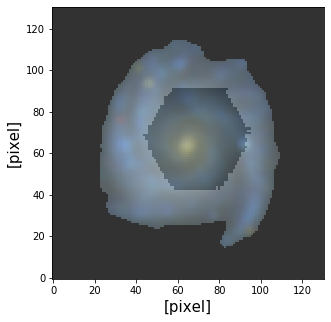

In [6]:
%matplotlib inline

from astropy.visualization import make_lupton_rgb

g = map_fluxes[3]*10
r = map_fluxes[4]*10
i = map_fluxes[5]*10

rgb_default = make_lupton_rgb(i, r, g)

fig1 = plt.figure(figsize=(5,5))
f1 = plt.subplot()
plt.xlabel('[pixel]', fontsize=15)
plt.ylabel('[pixel]', fontsize=15)

plt.imshow(rgb_default, origin='lower', alpha=1.0)
plt.imshow(spec_region, origin='lower', cmap='Greys', alpha=0.2)

<font size="4"> **Check SEDs of pixels**: including photometric and spectroscopic. </font>

In [7]:
# get filters
nbands = int(header['nfilters'])
filters = []
for bb in range(0,nbands):
    str_temp = 'fil%d' % bb
    filters.append(header[str_temp])

# get central wavelength of filters
from piXedfit.utils.filtering import cwave_filters
photo_wave = cwave_filters(filters)

<font size="4"> **Plot SEDs of some pixels in the central region**. In this data cube, the spectroscopic SEDs have not been corrected for the wavelength-dependent mismatch with the photometric SEDs. This will be done in next step using `piXedfit.piXedfit_spectrophotometric.match_specphoto`. </font>

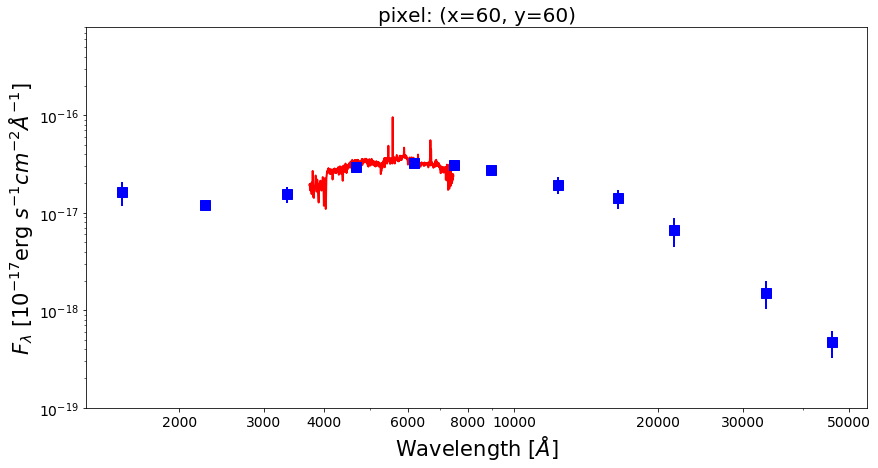

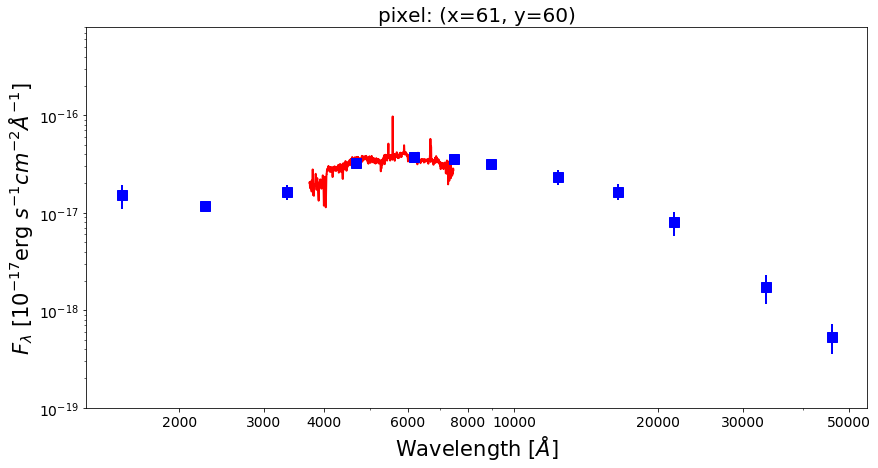

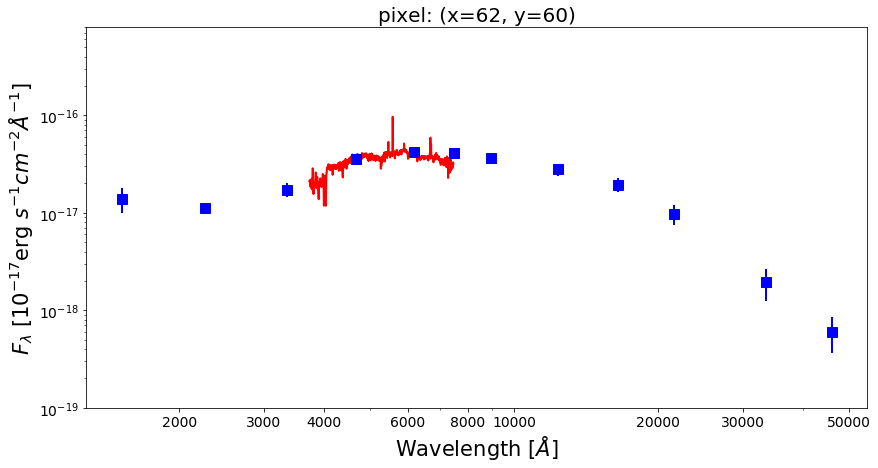

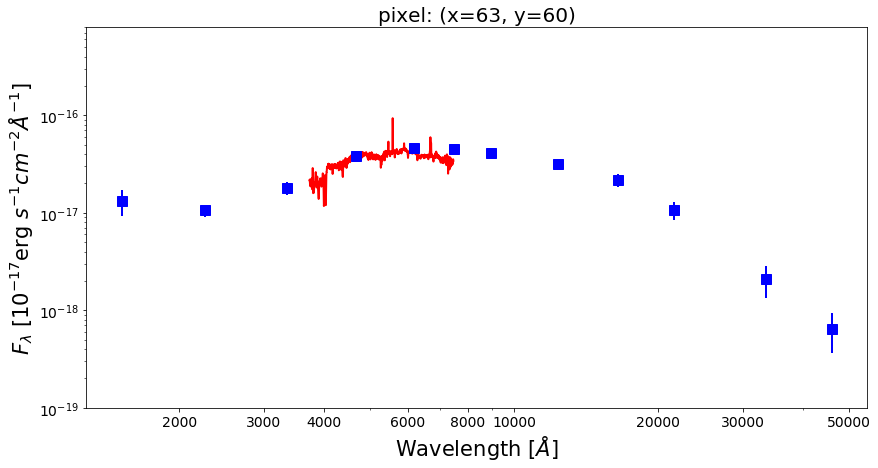

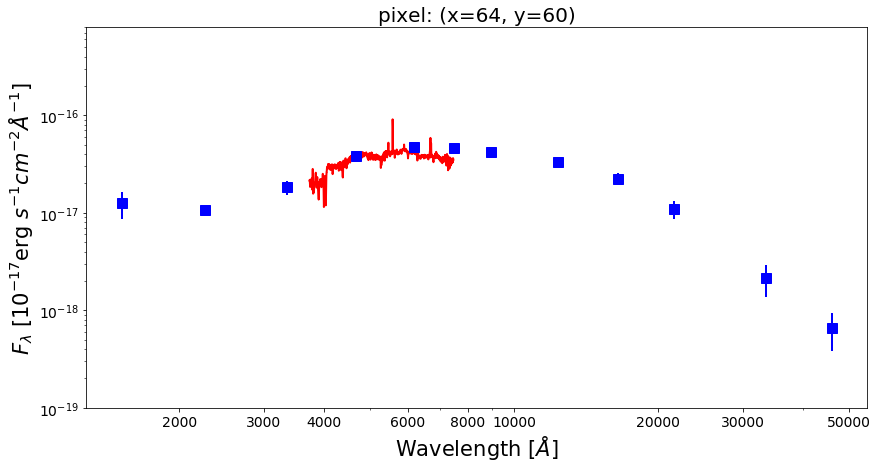

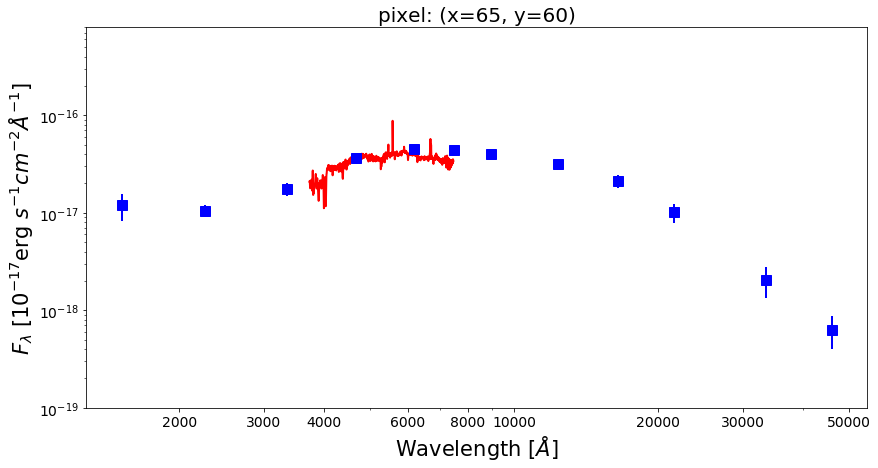

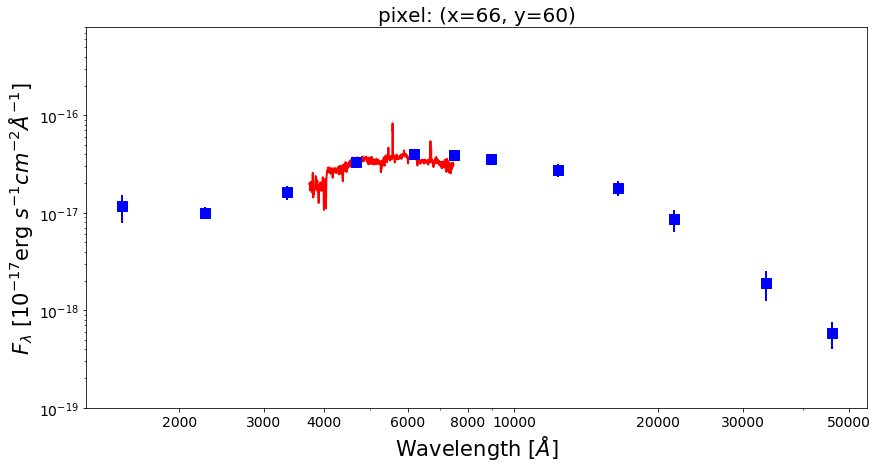

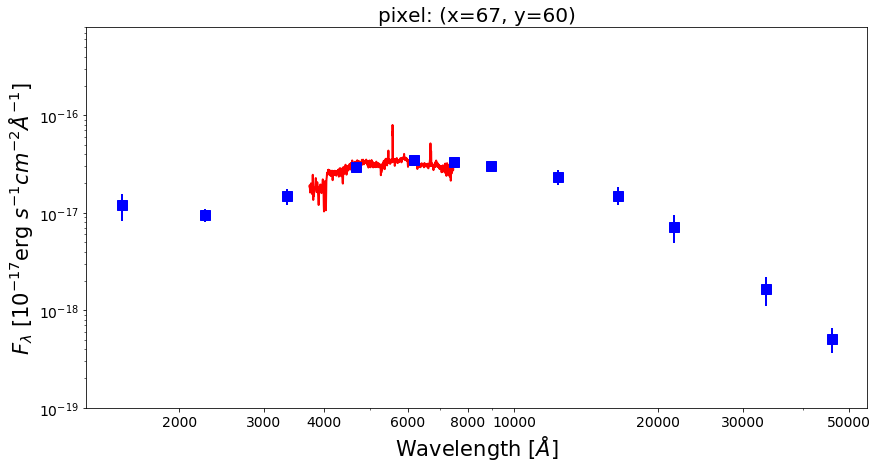

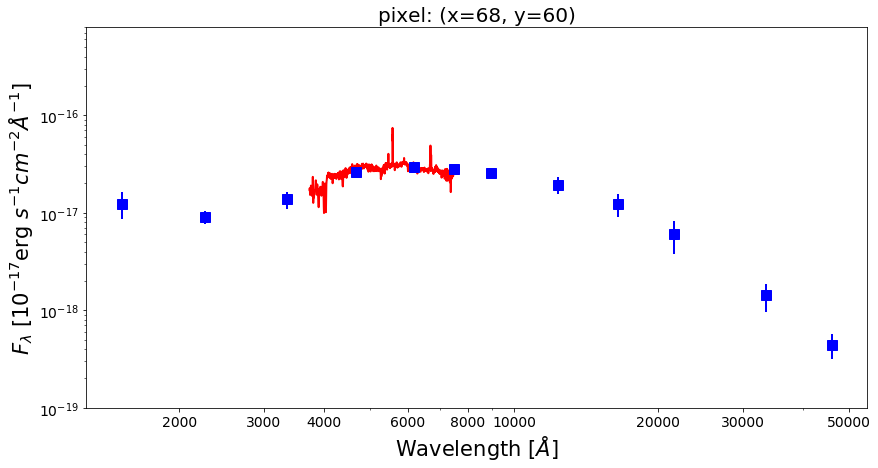

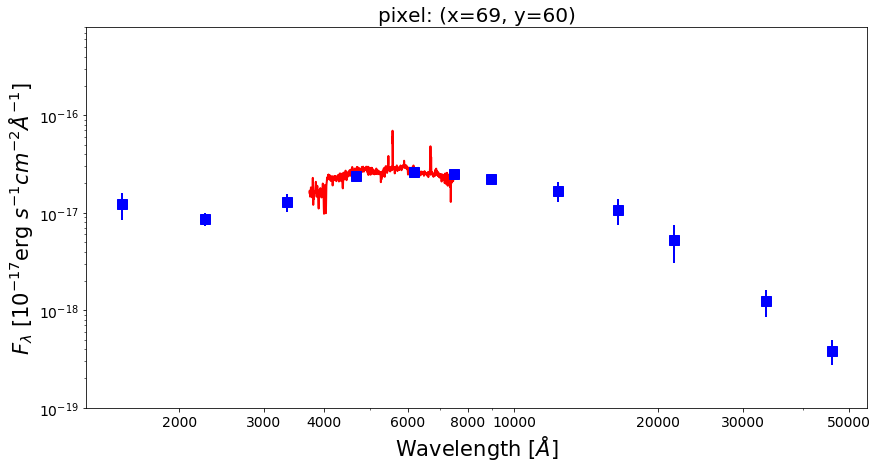

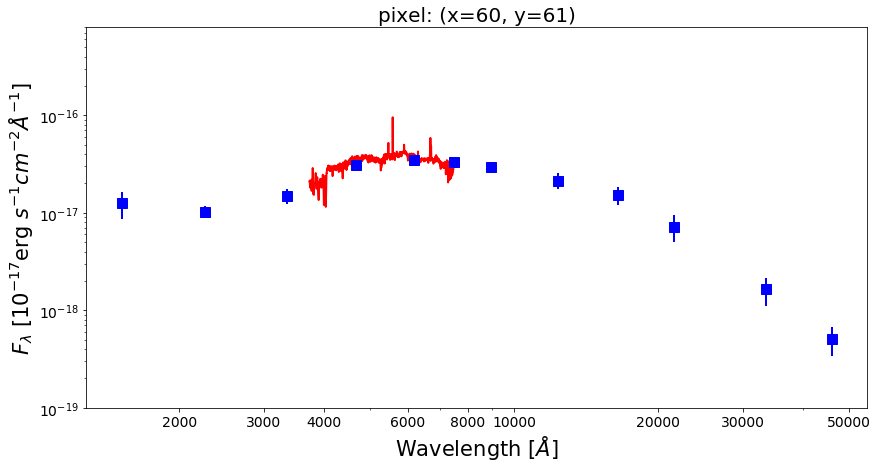

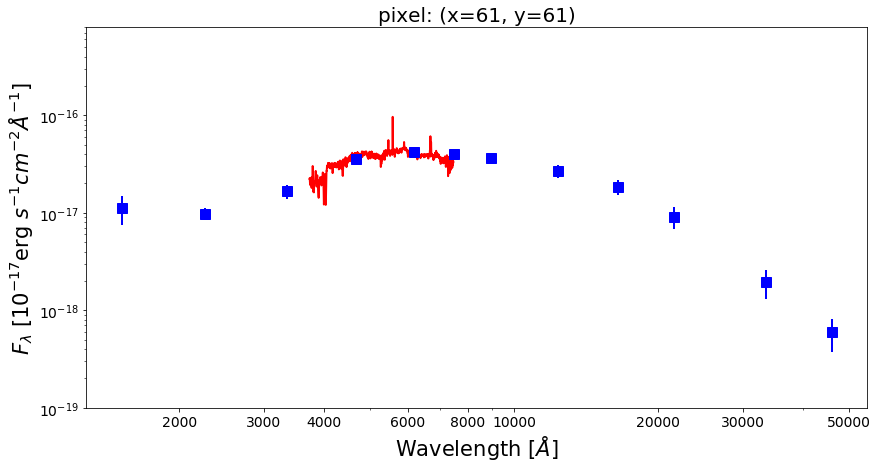

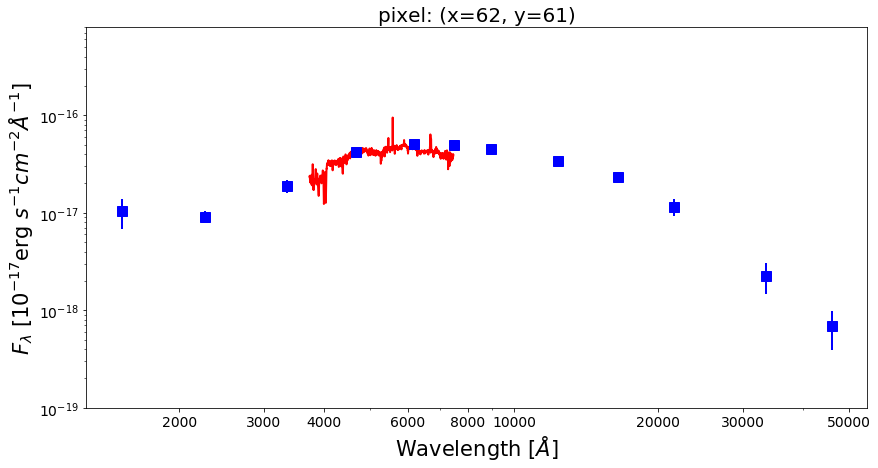

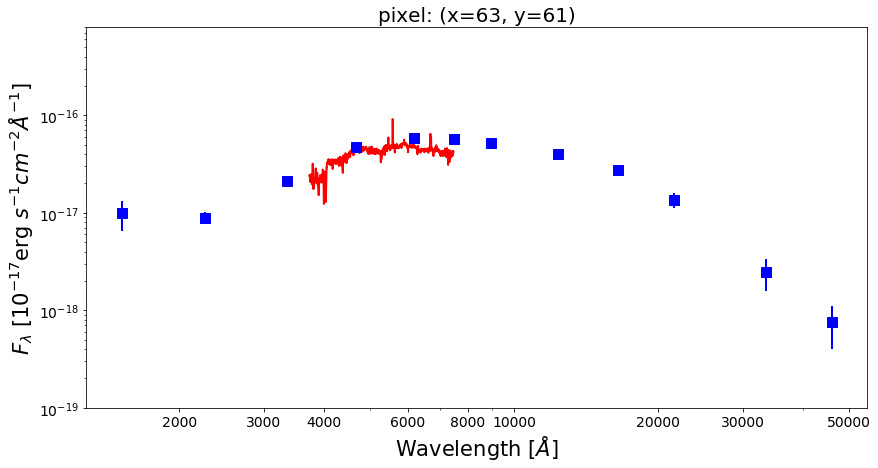

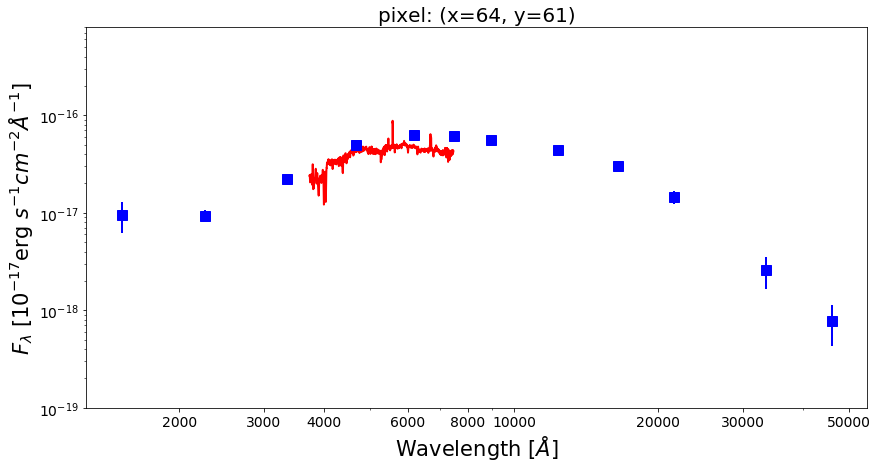

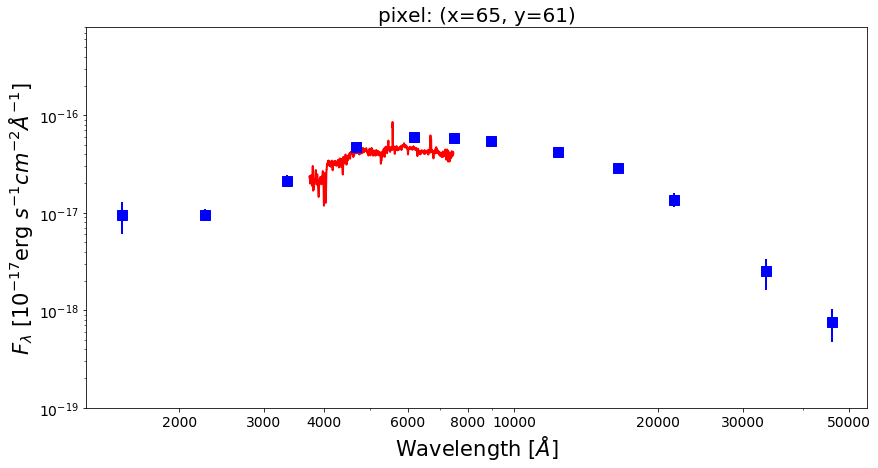

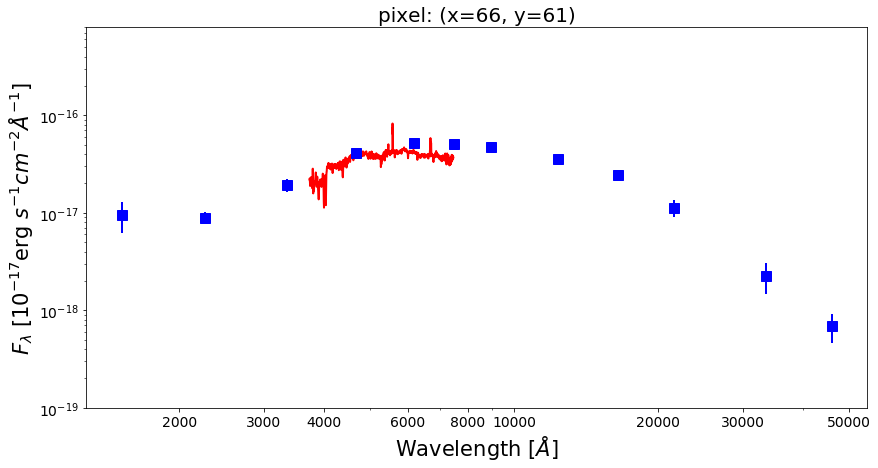

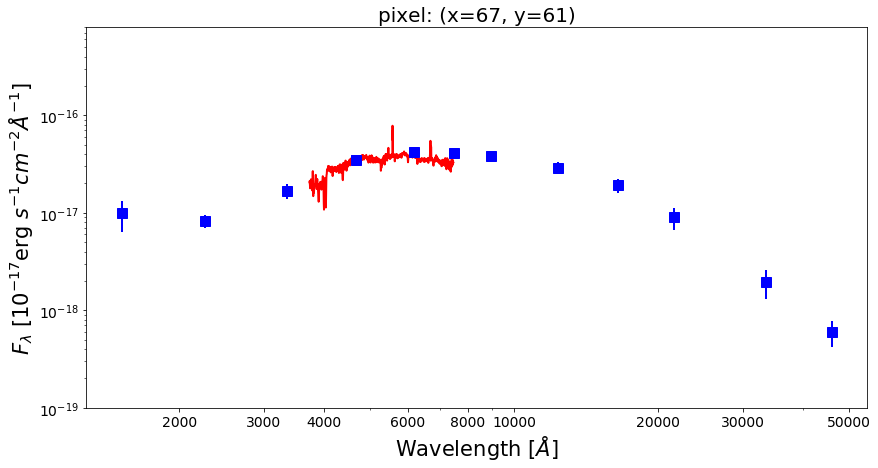

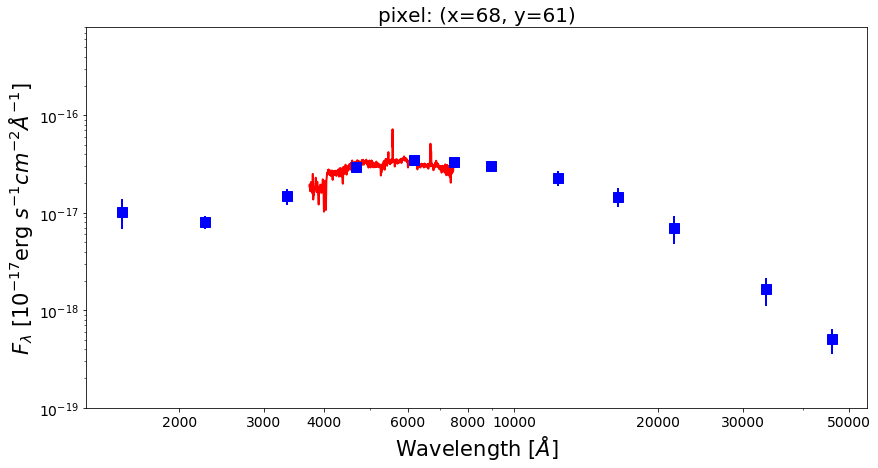

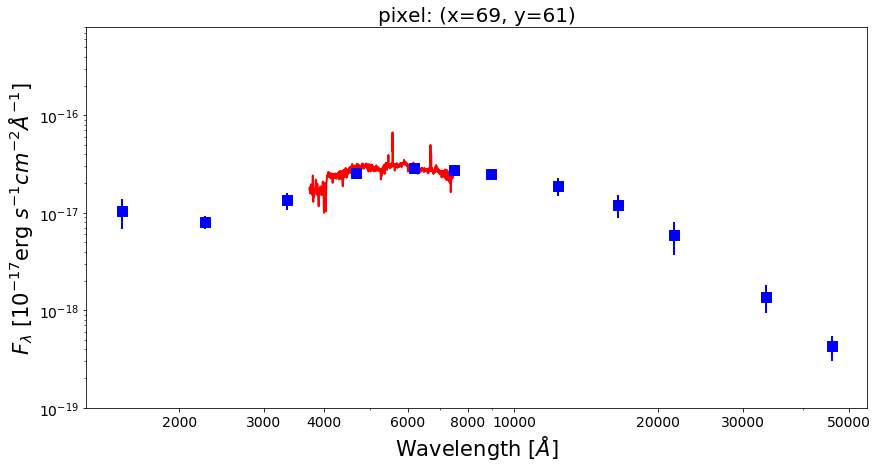

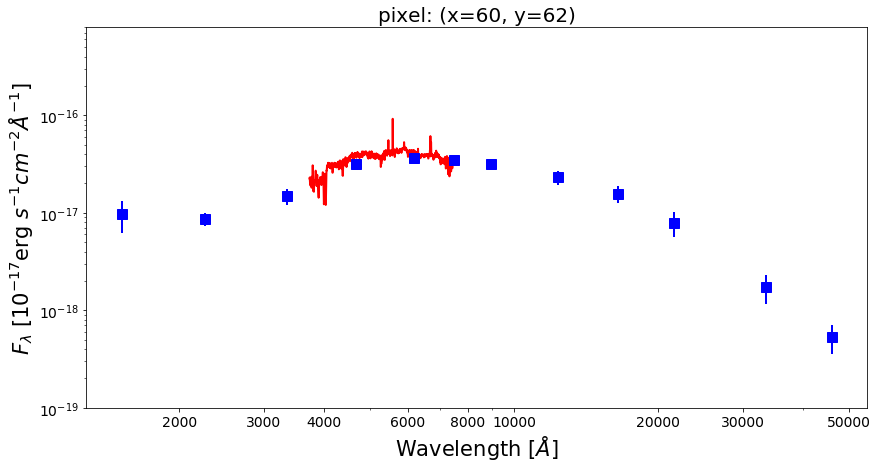

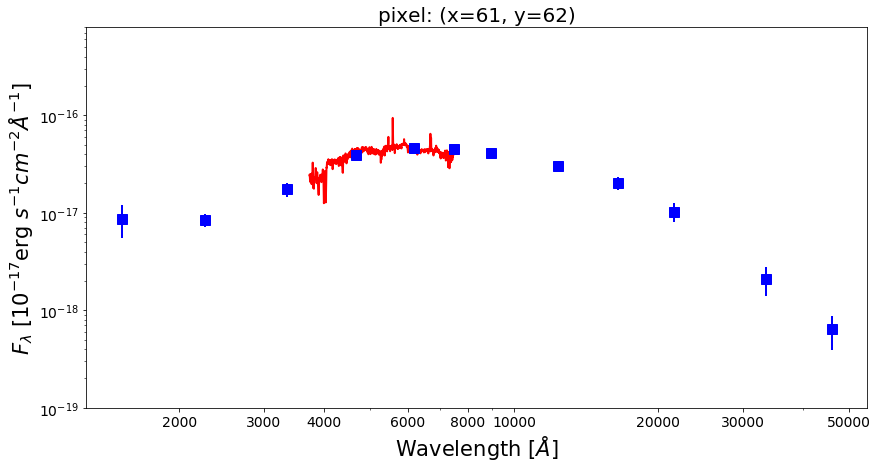

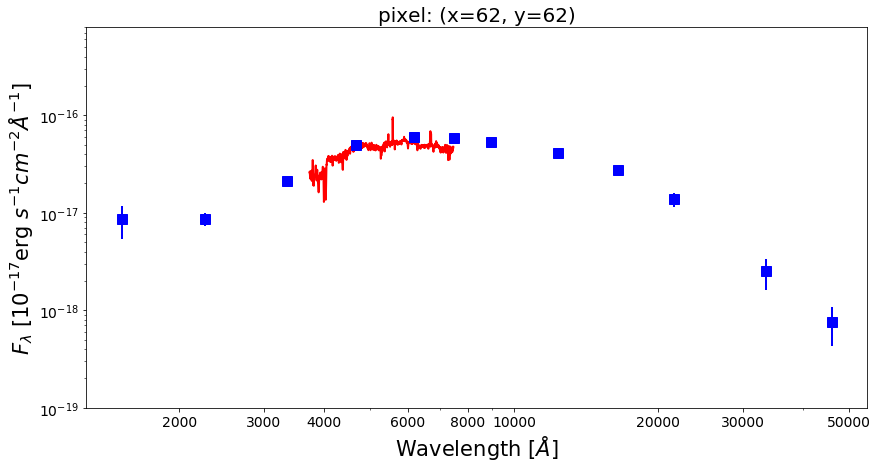

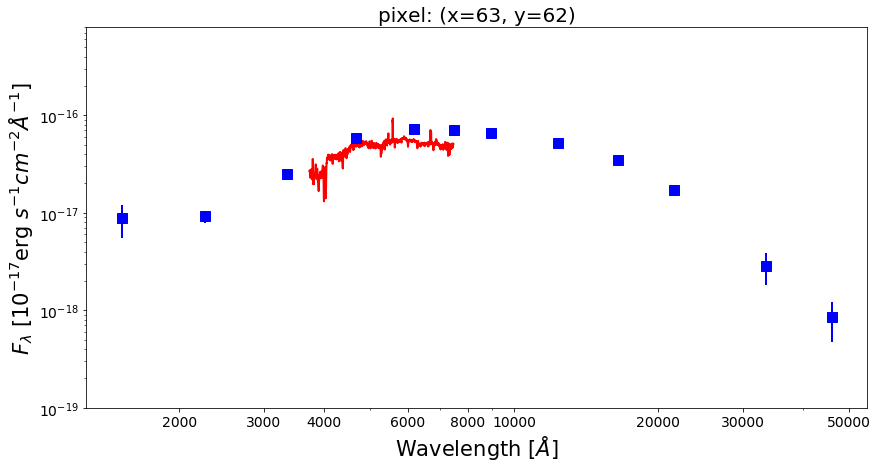

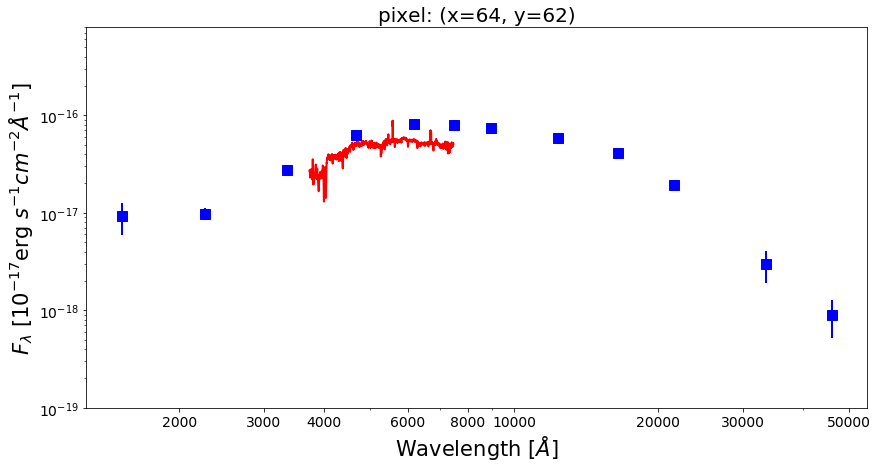

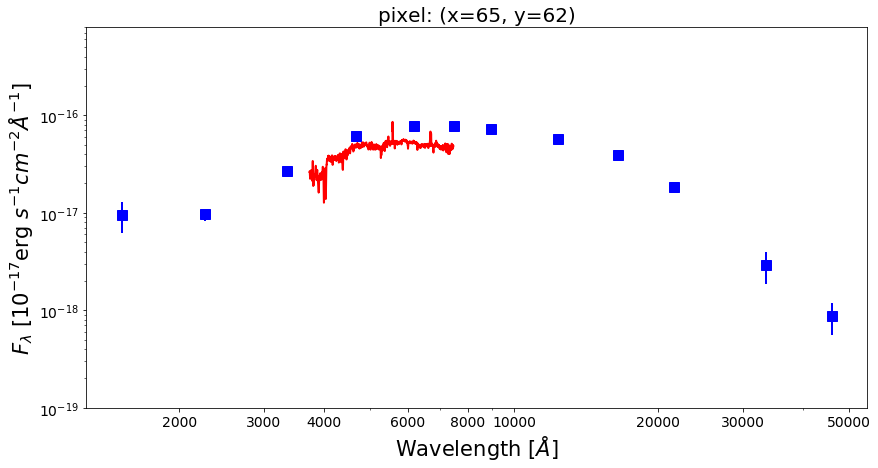

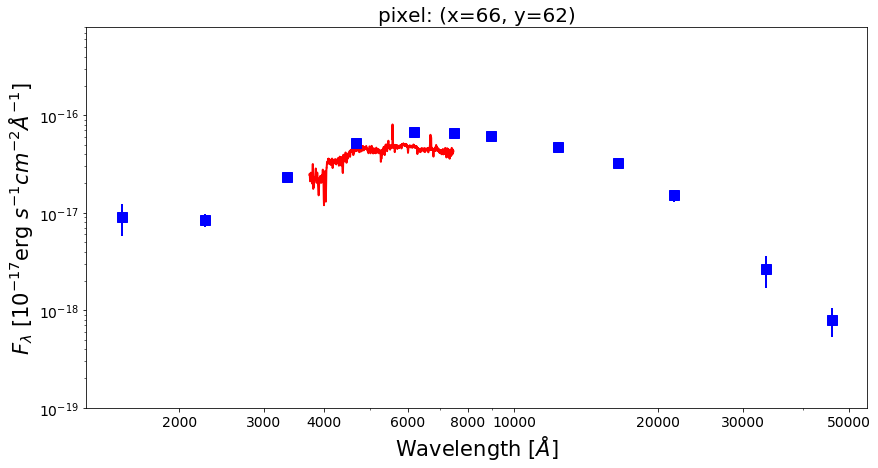

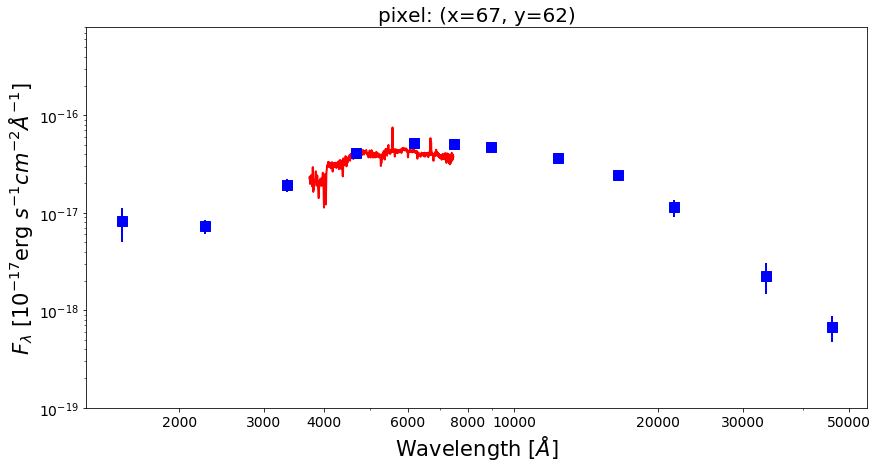

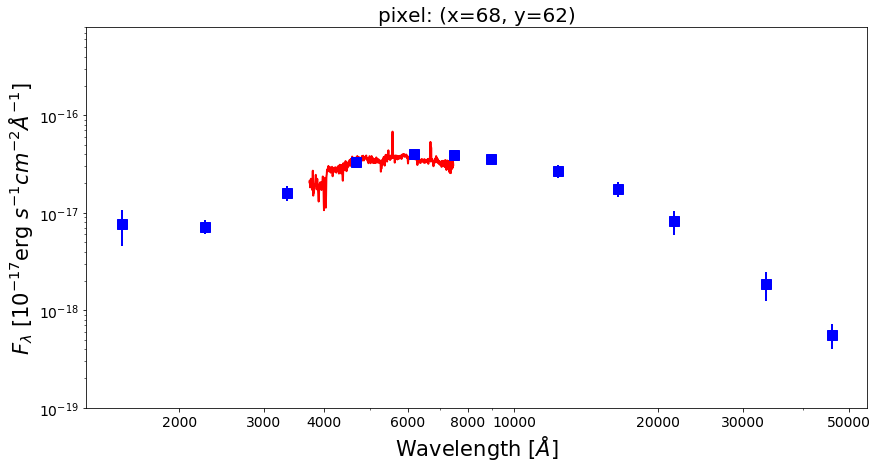

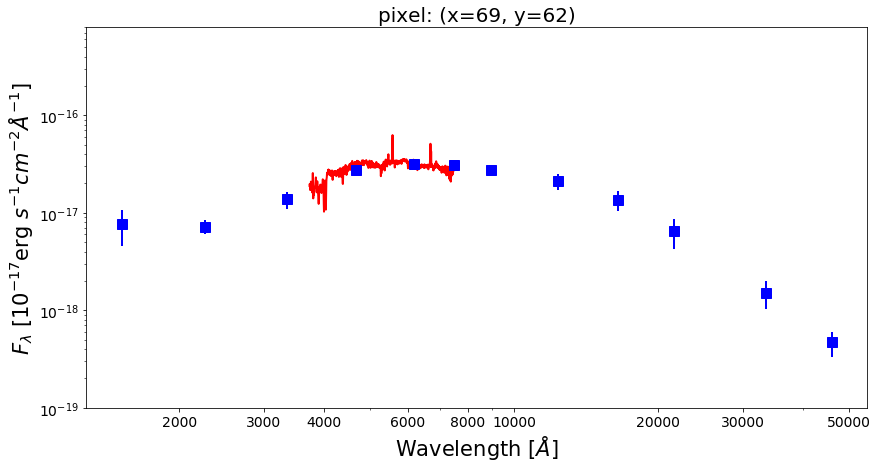

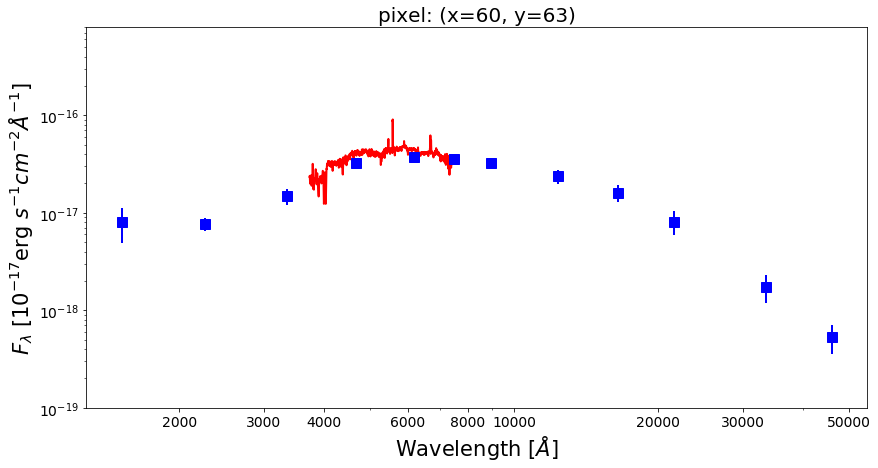

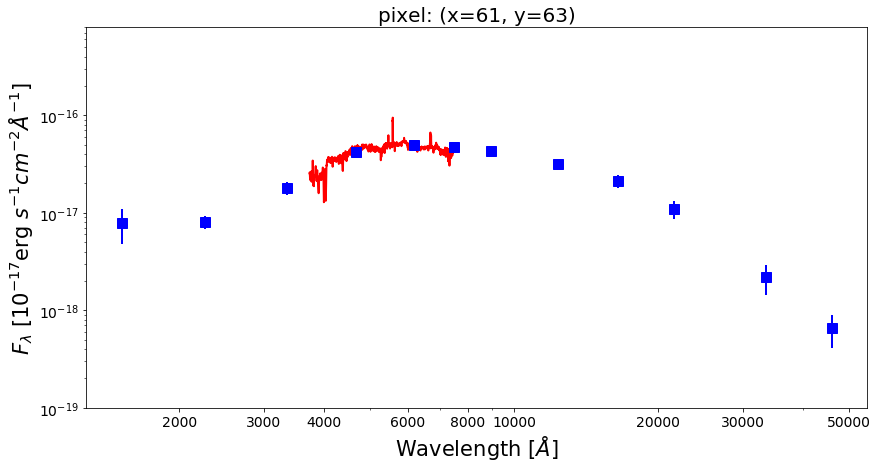

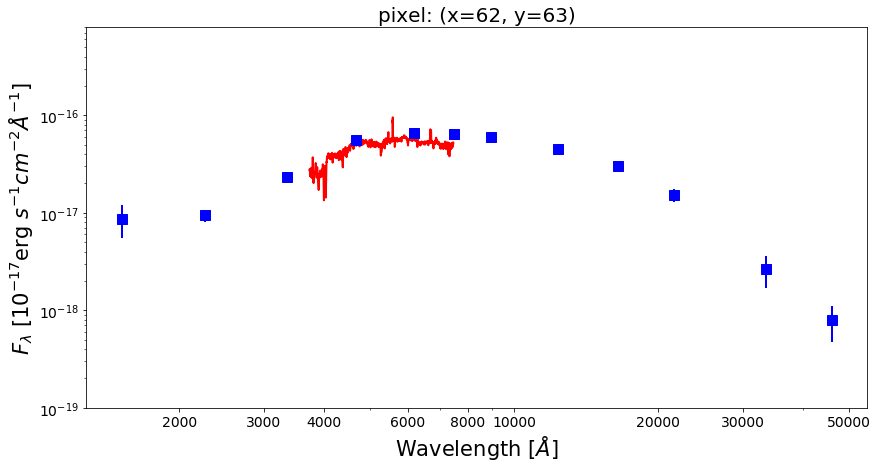

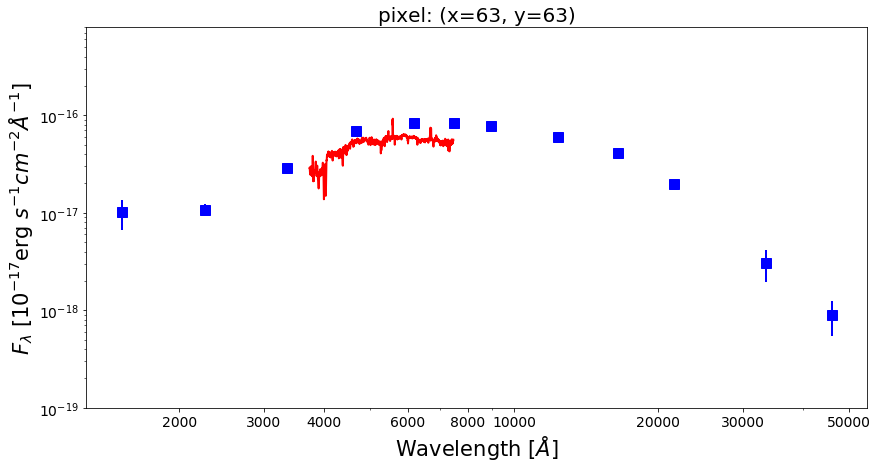

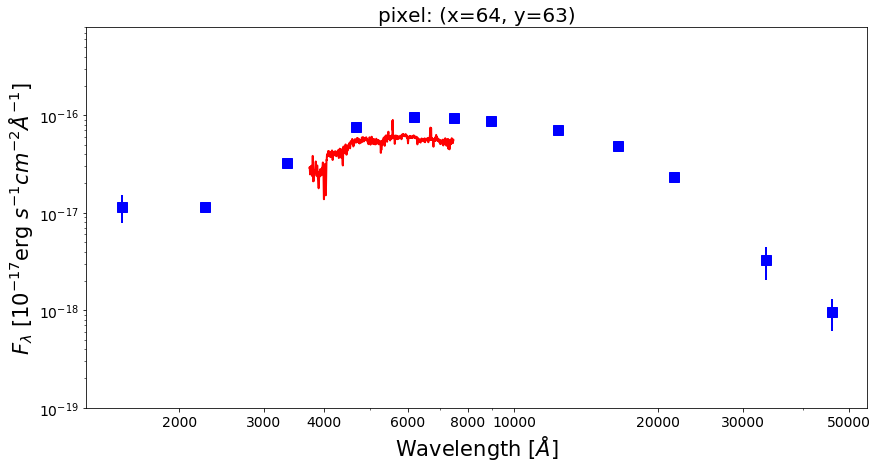

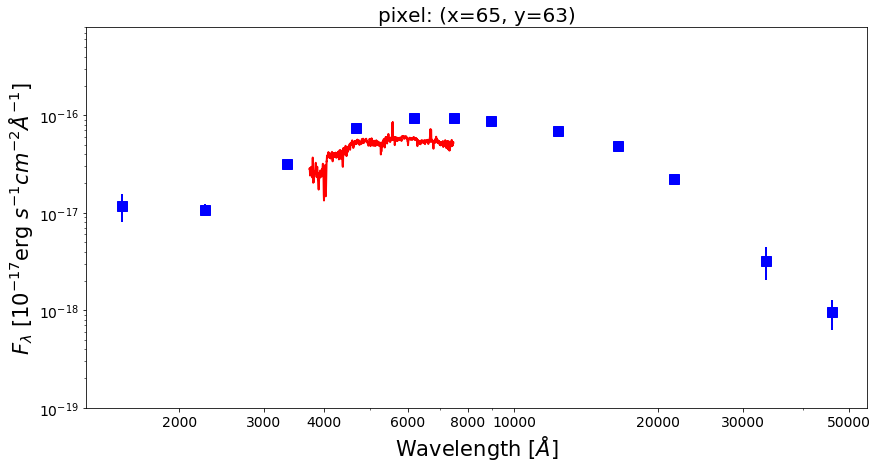

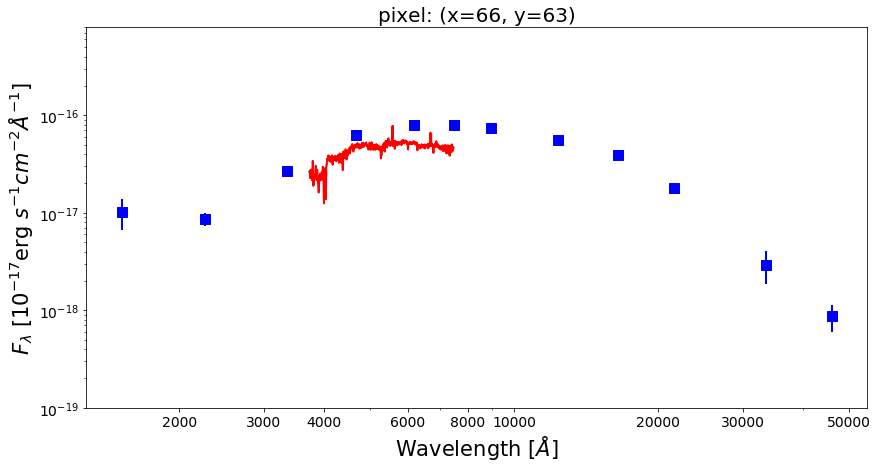

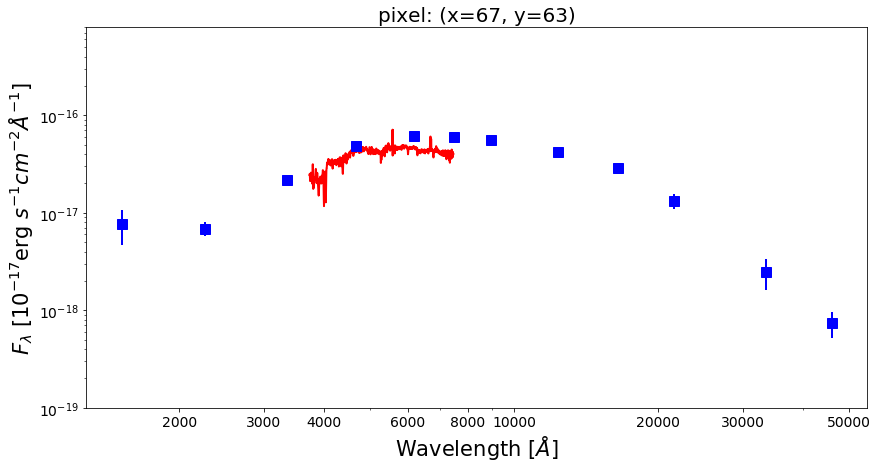

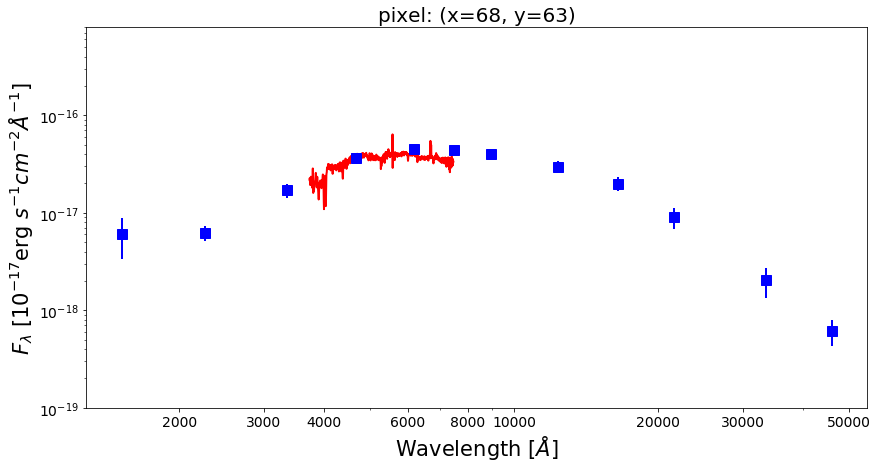

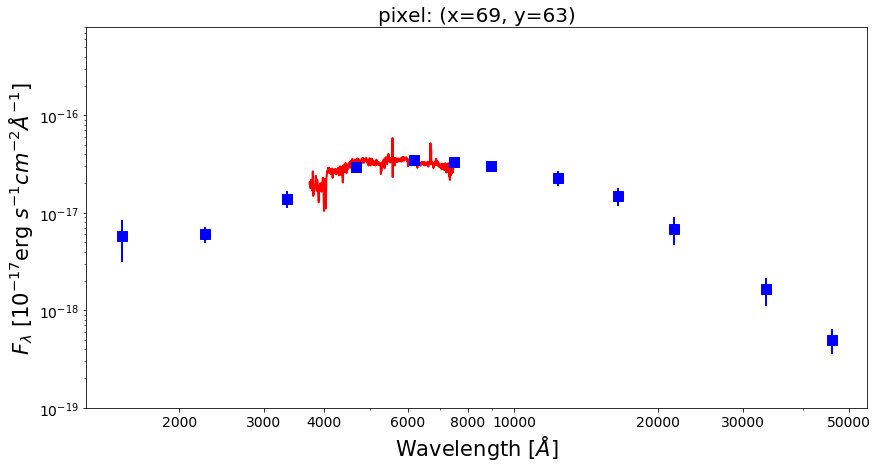

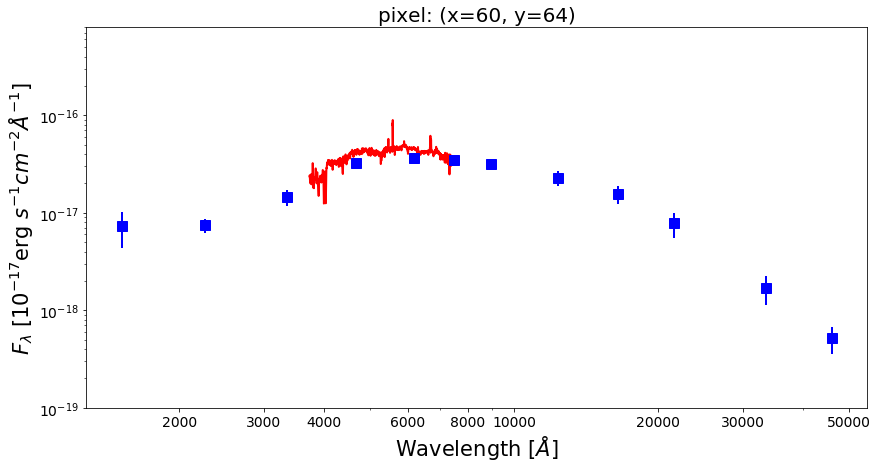

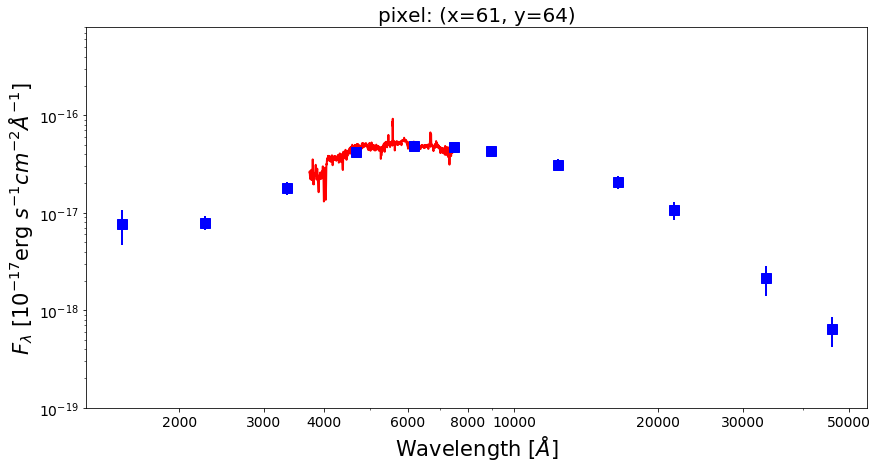

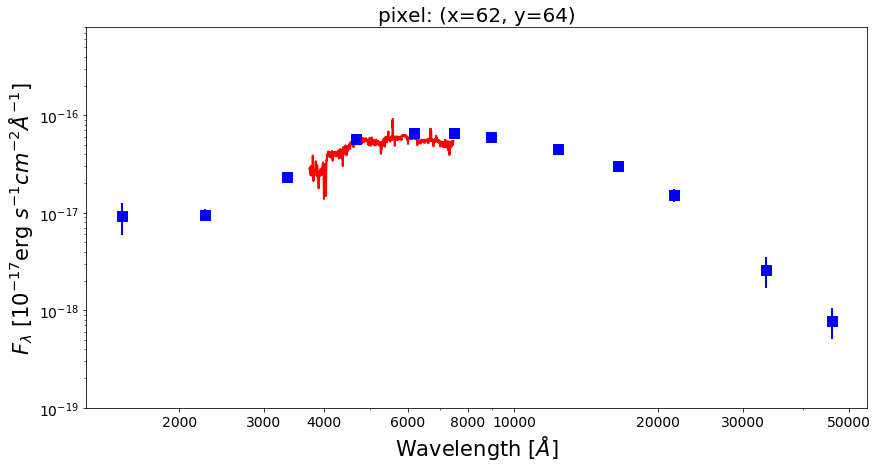

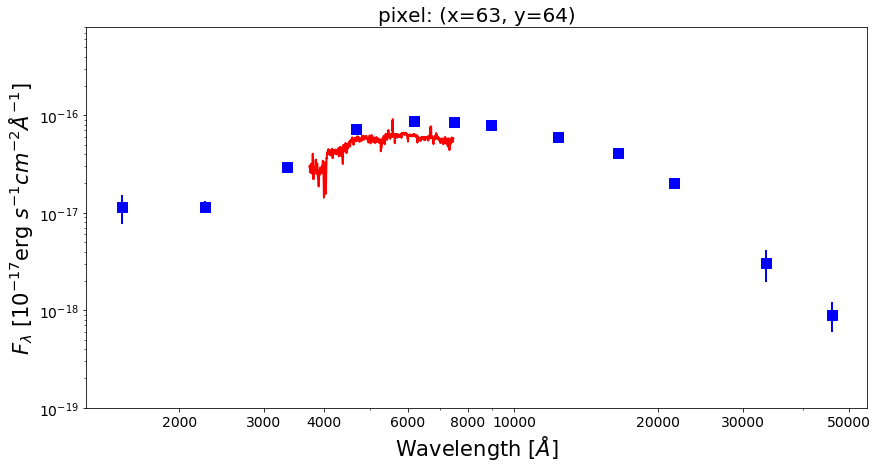

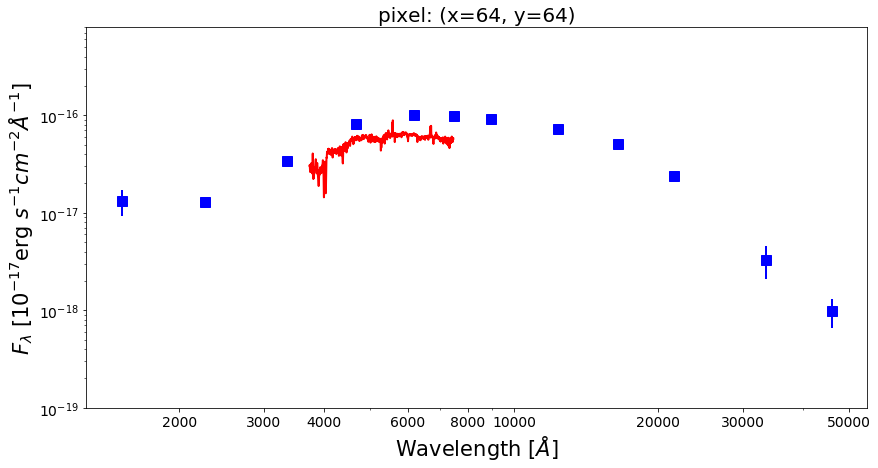

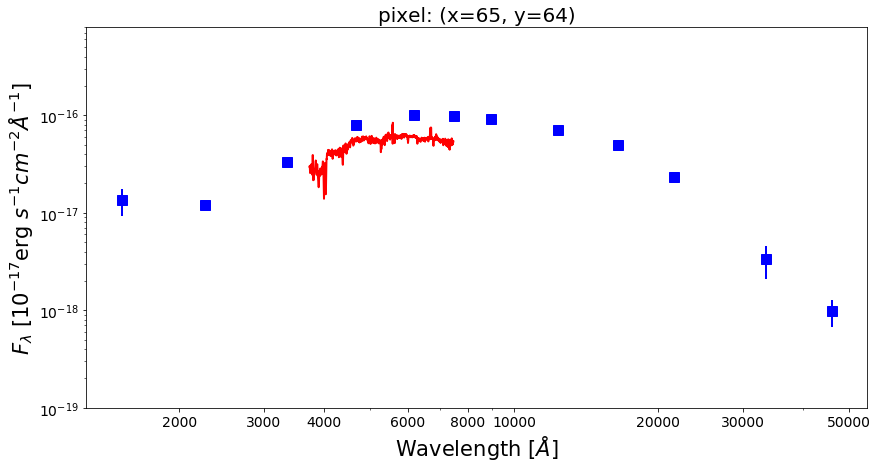

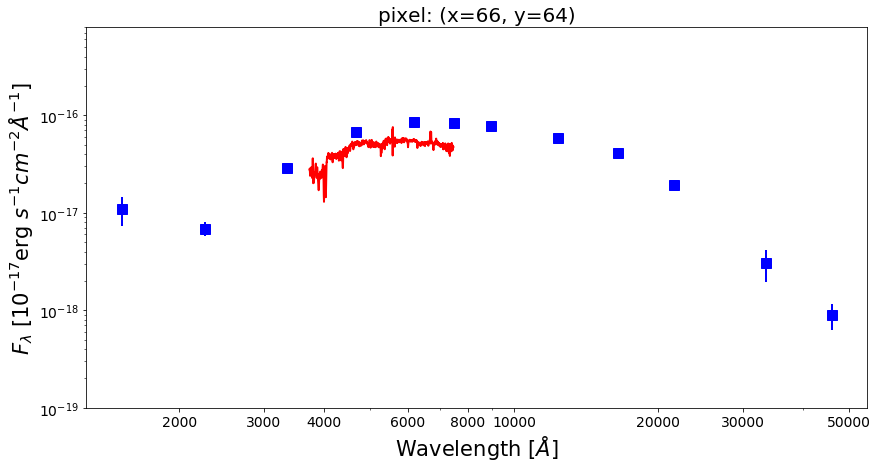

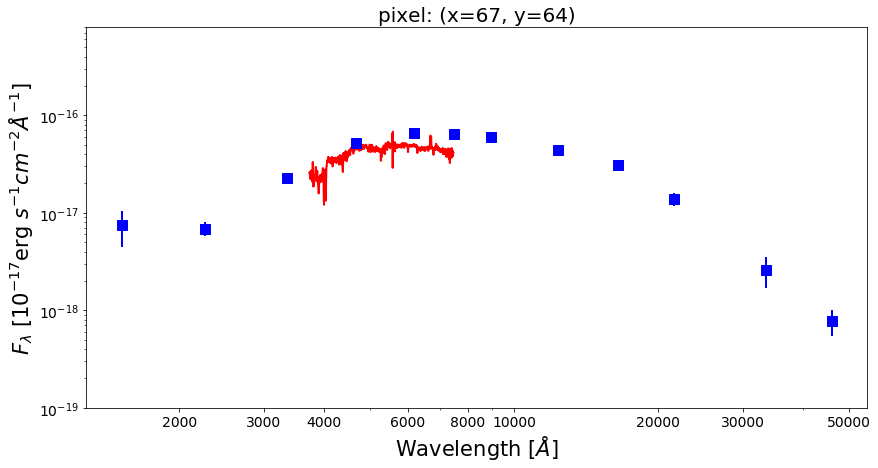

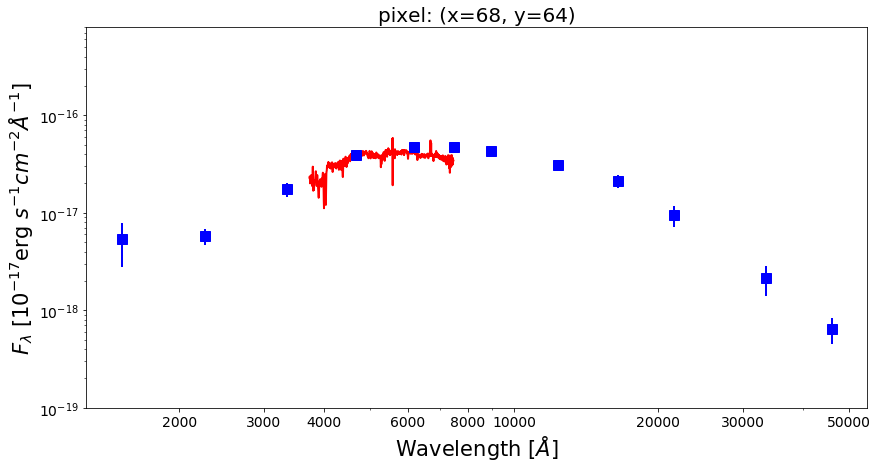

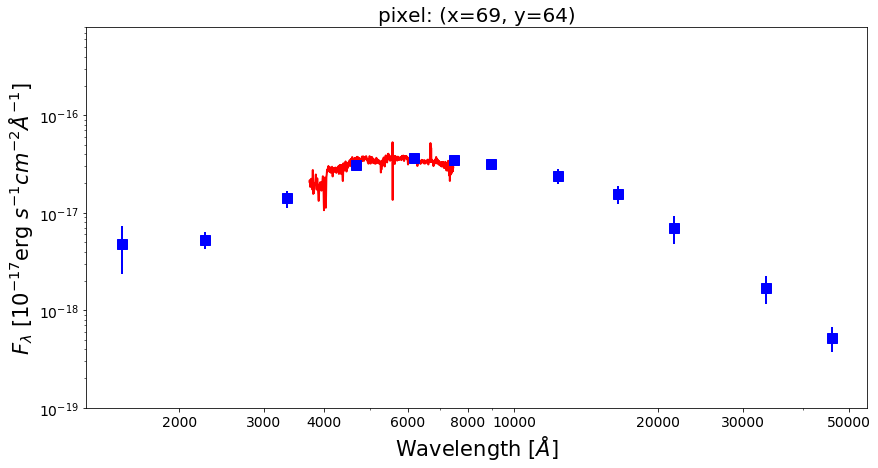

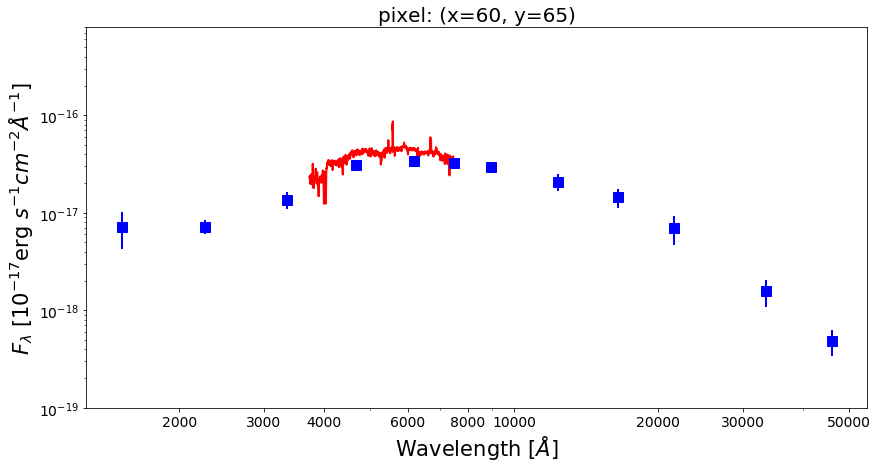

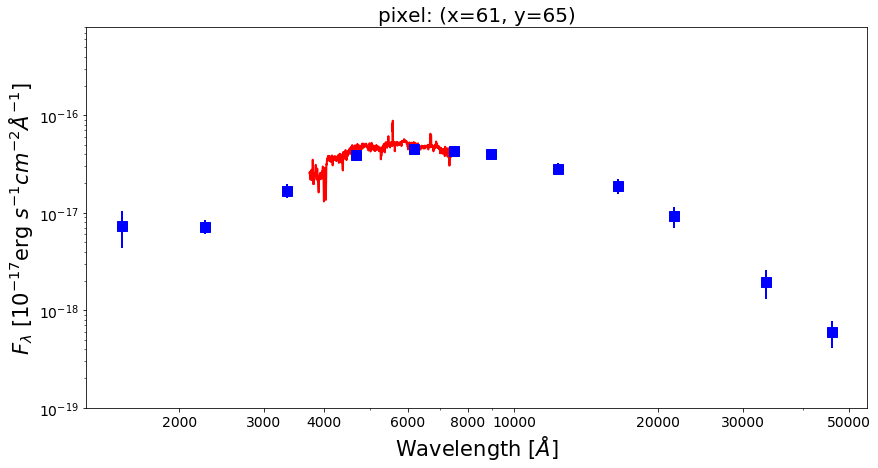

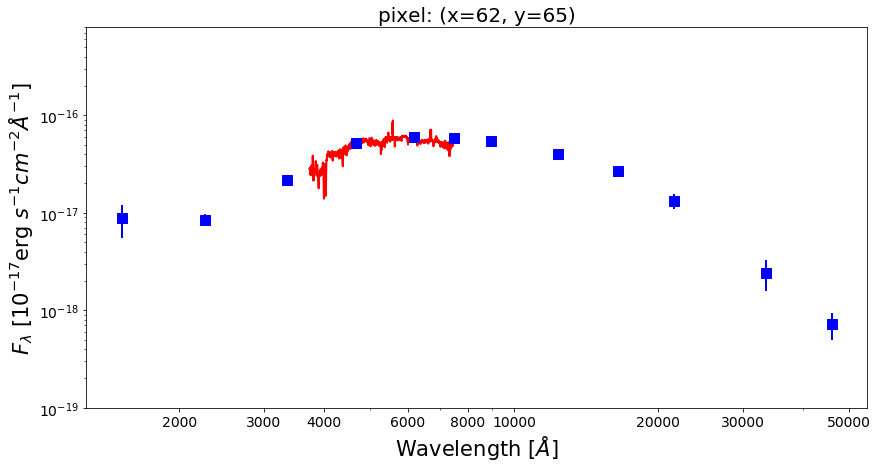

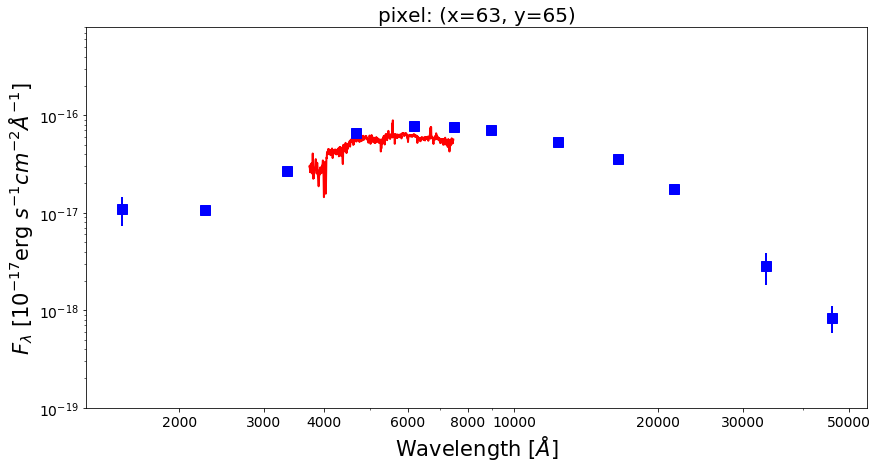

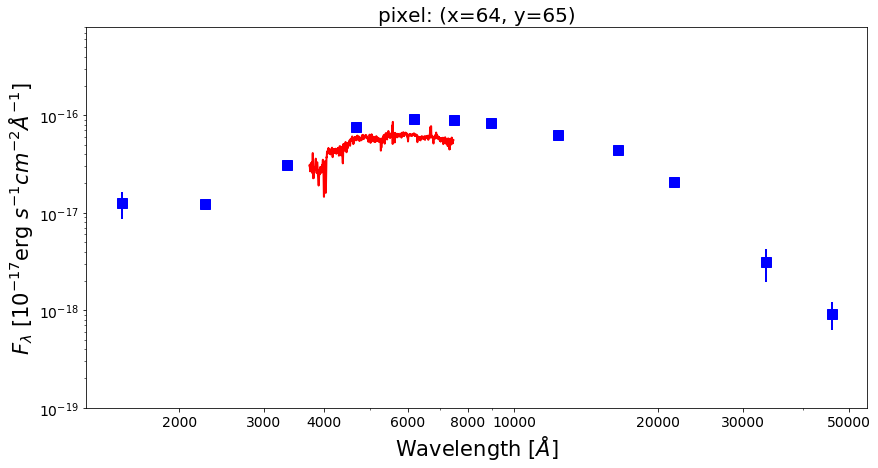

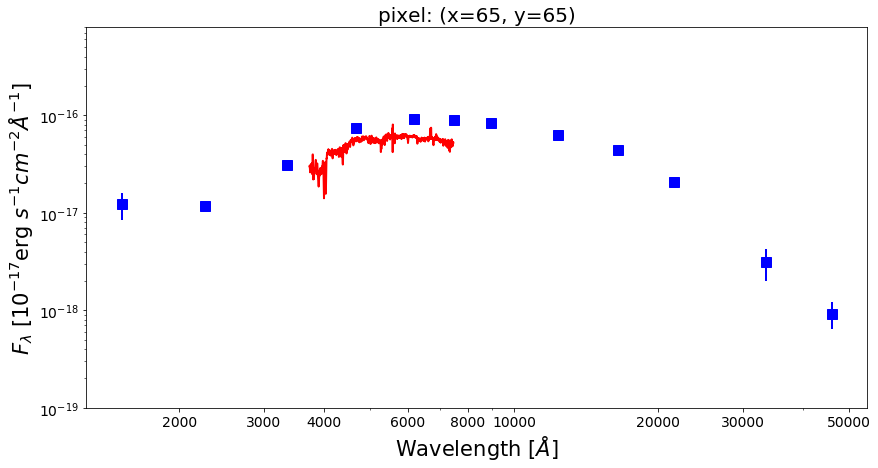

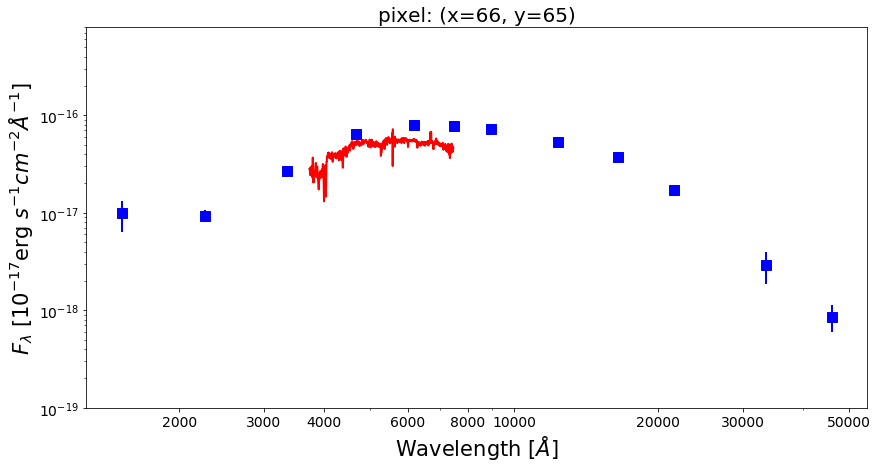

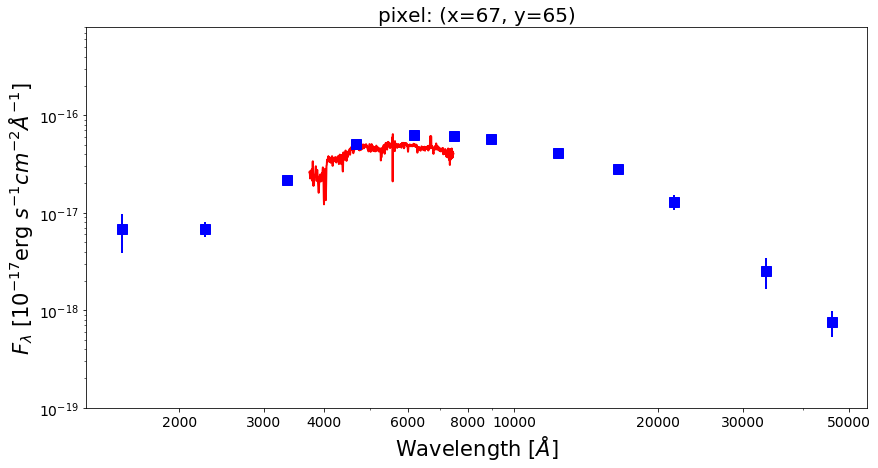

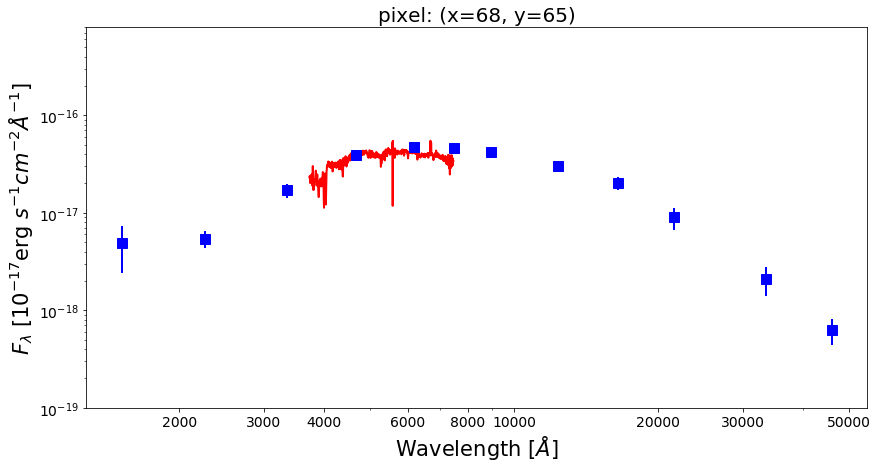

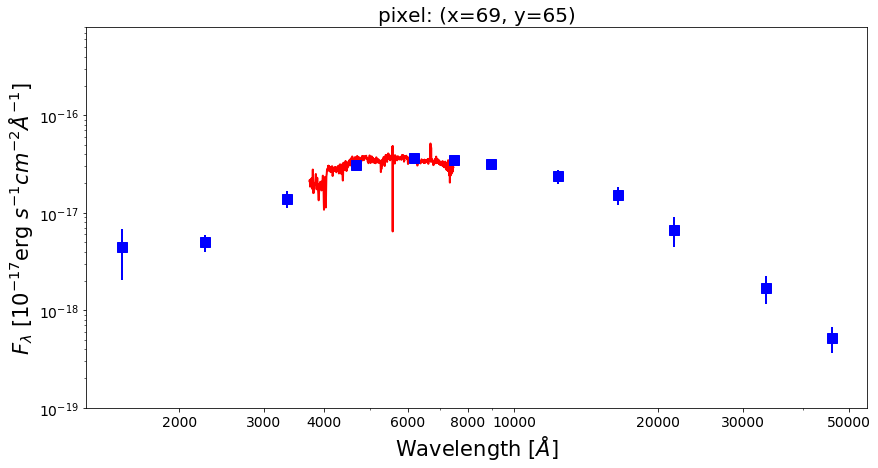

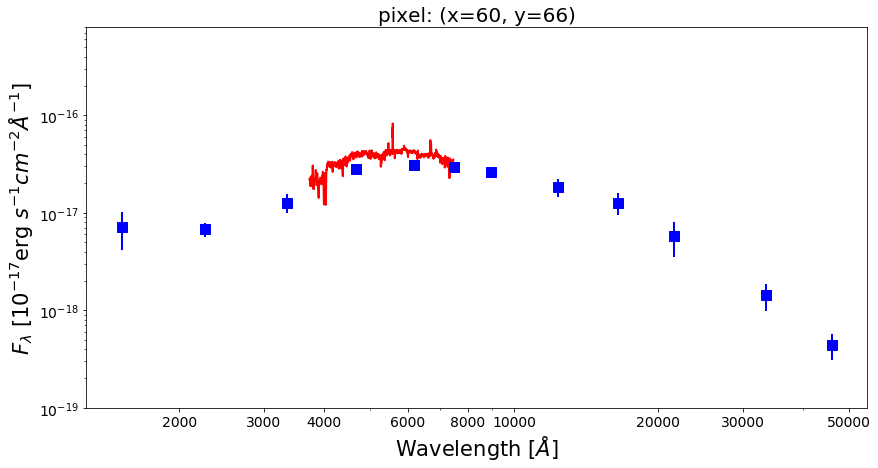

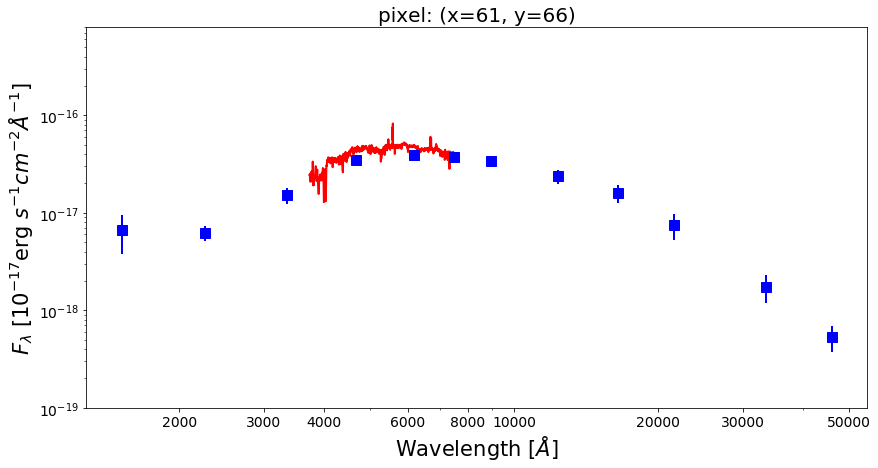

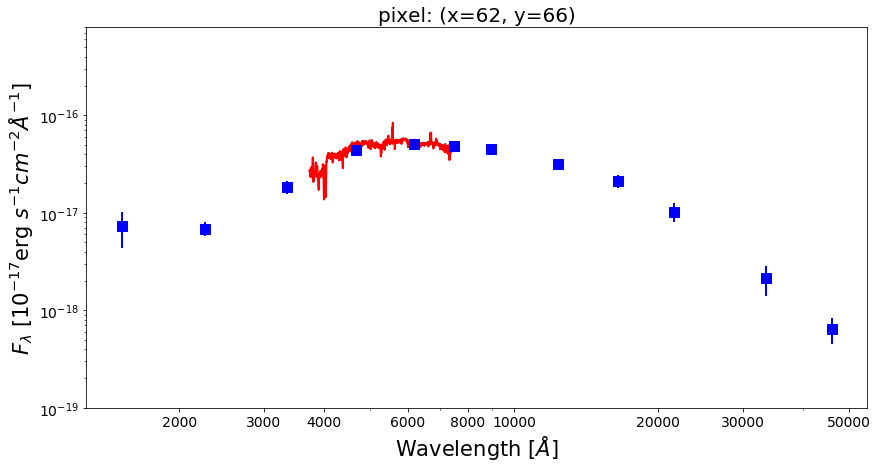

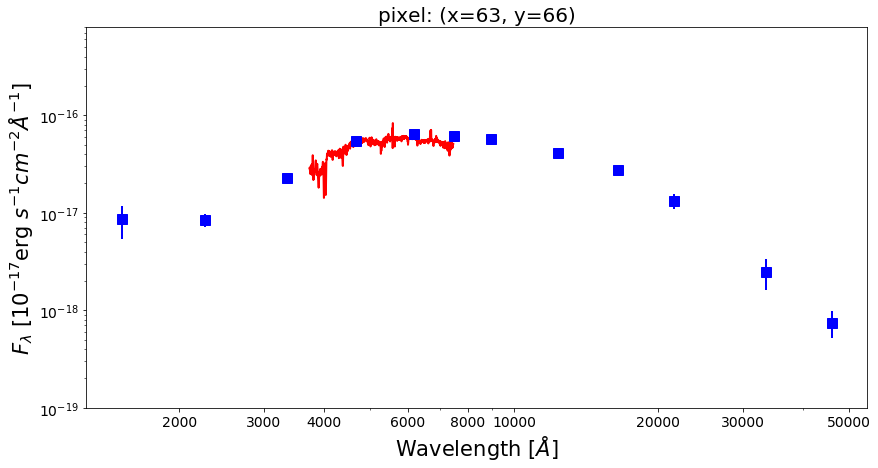

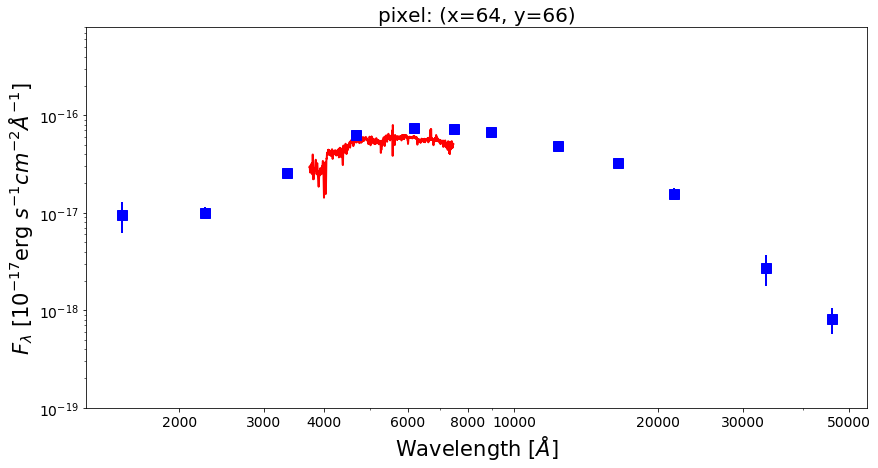

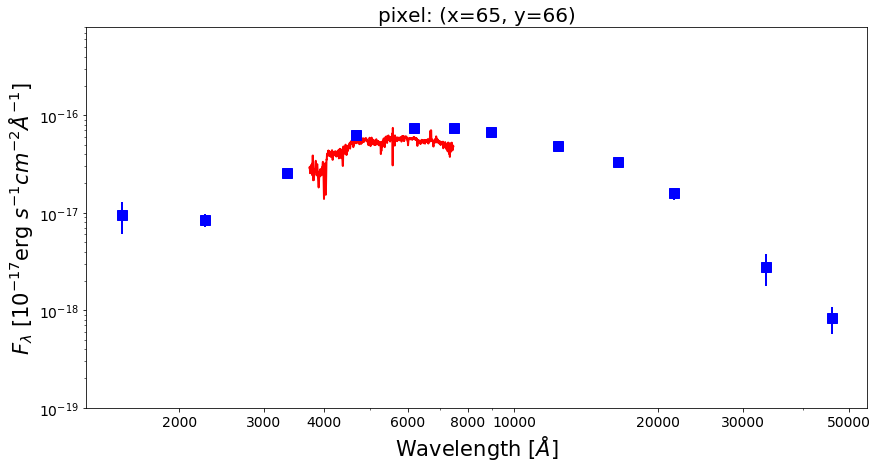

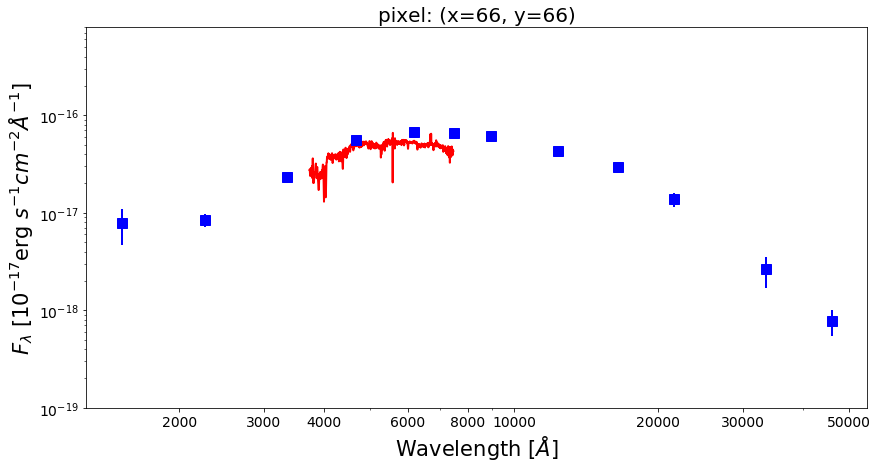

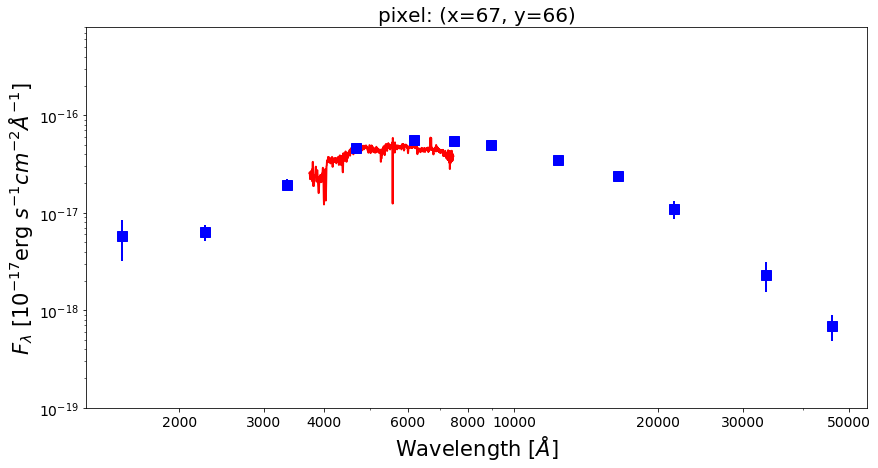

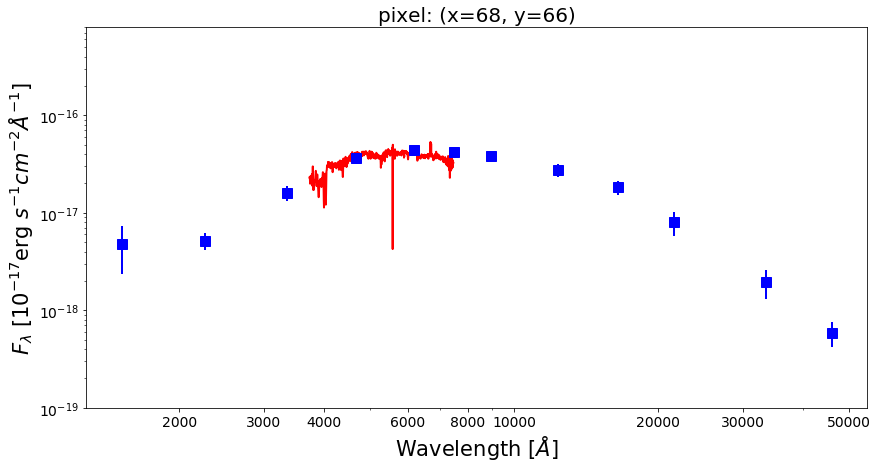

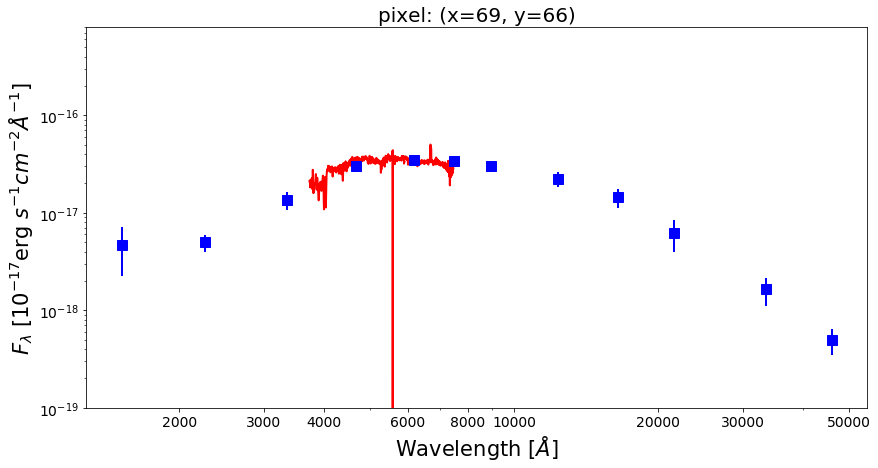

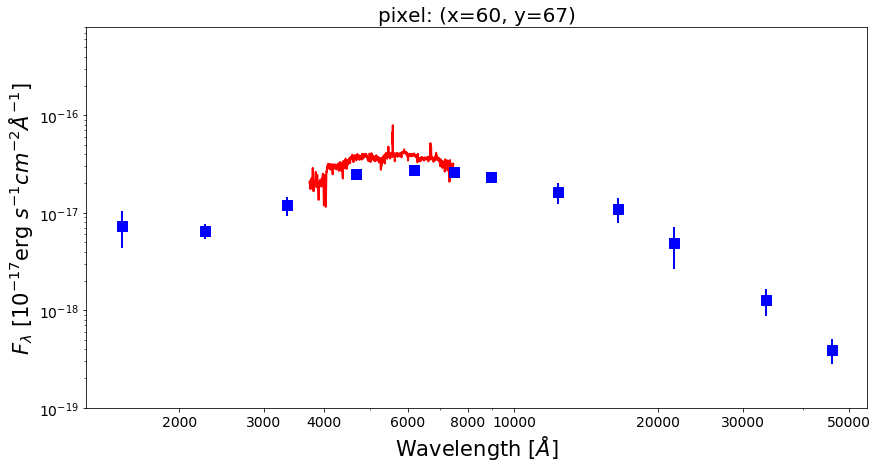

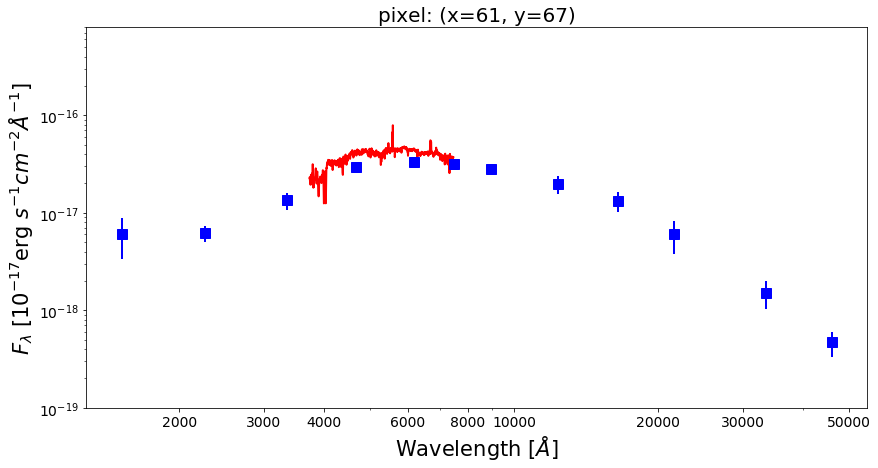

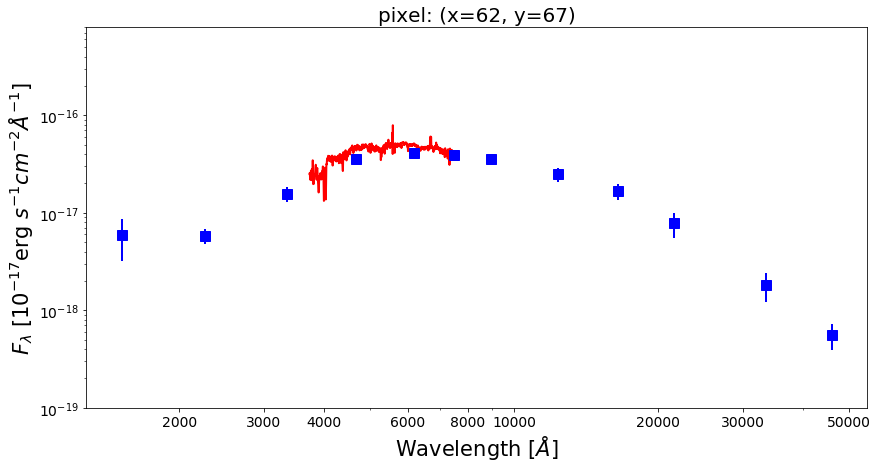

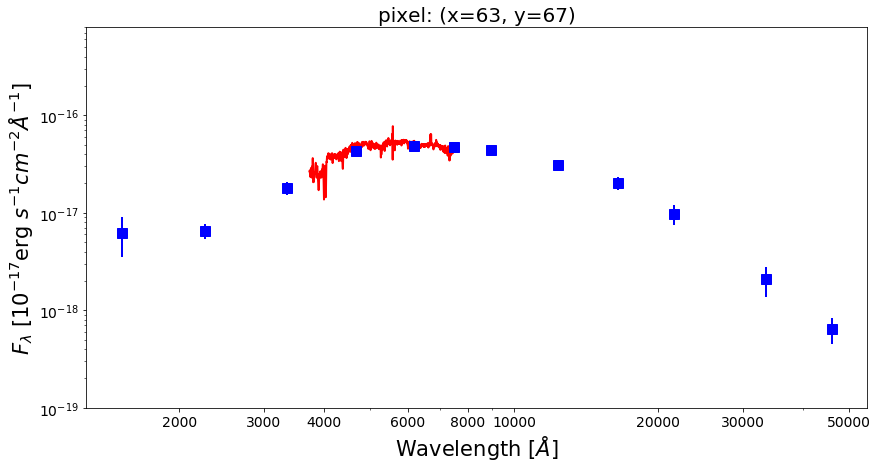

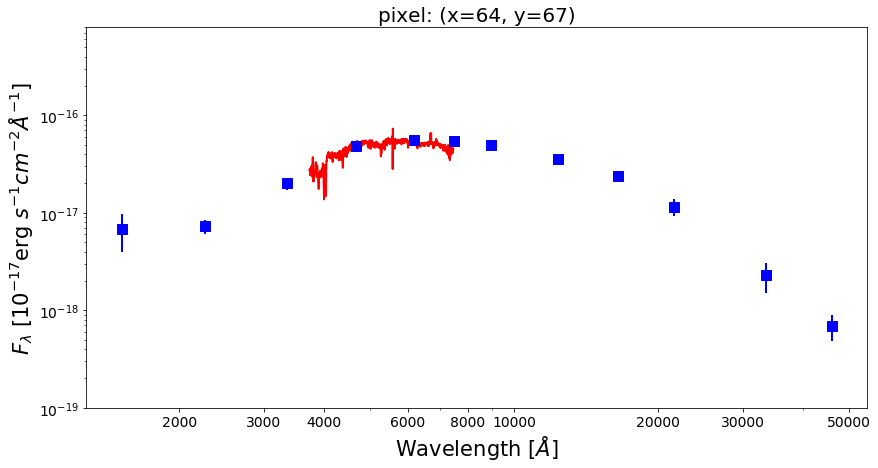

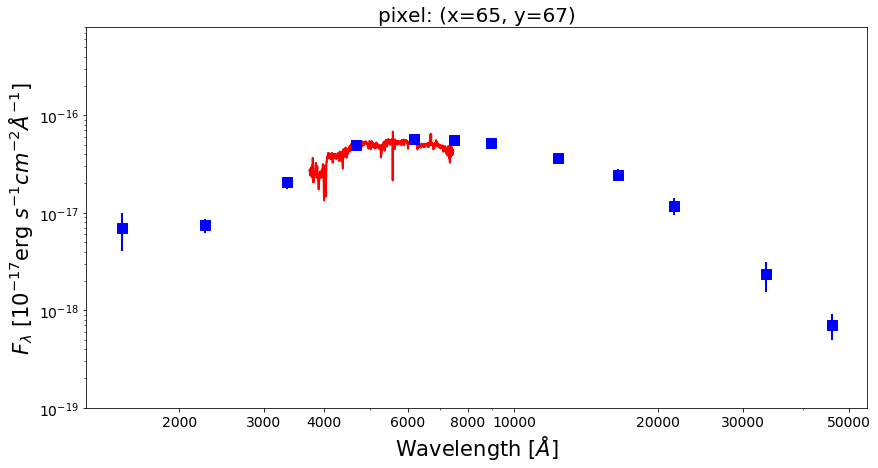

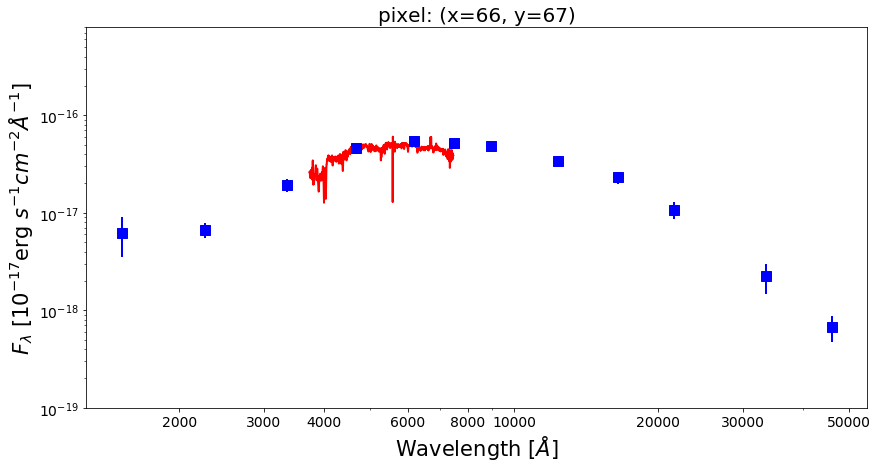

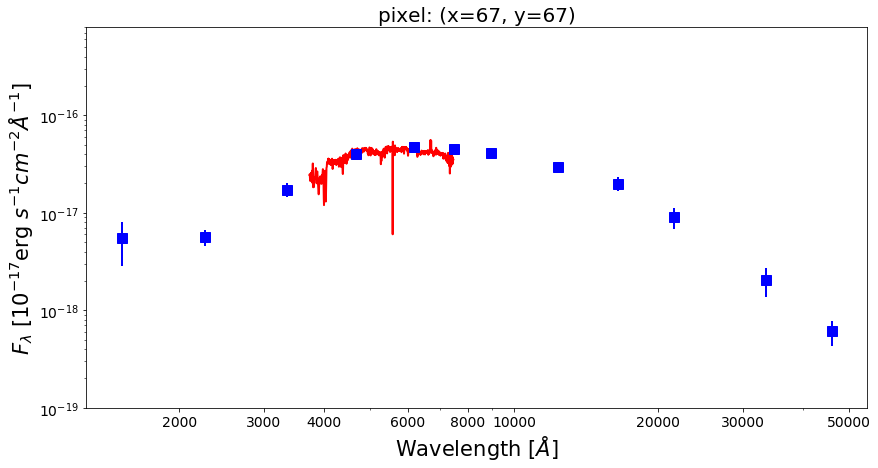

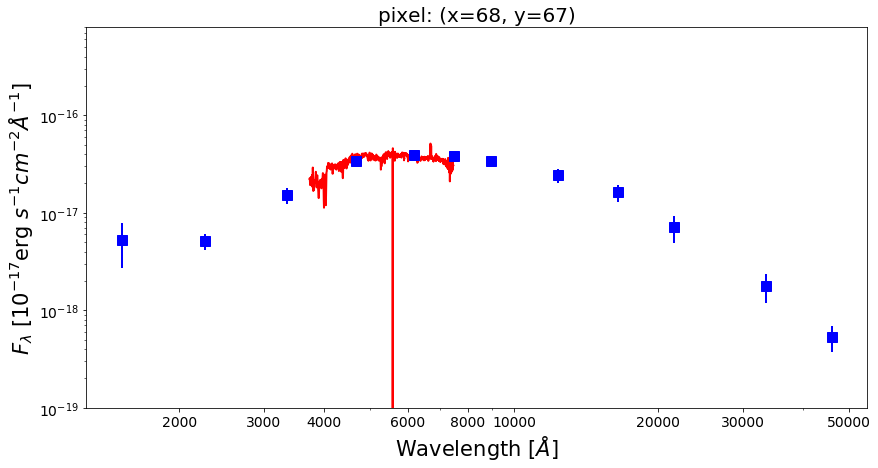

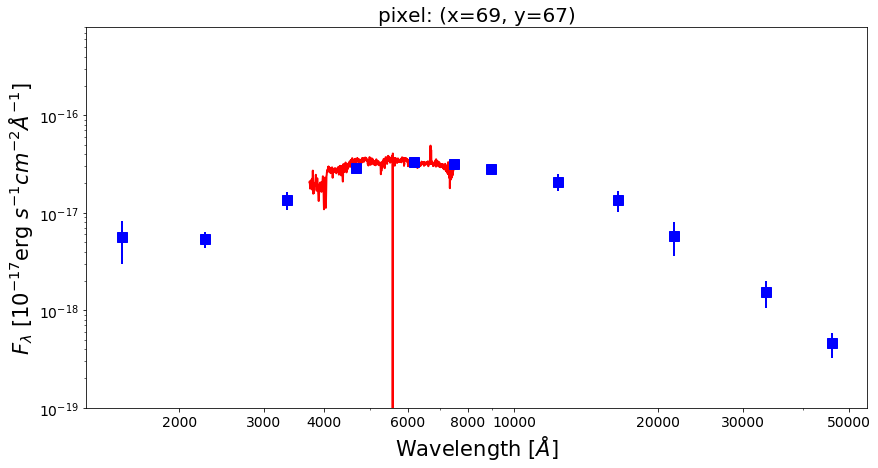

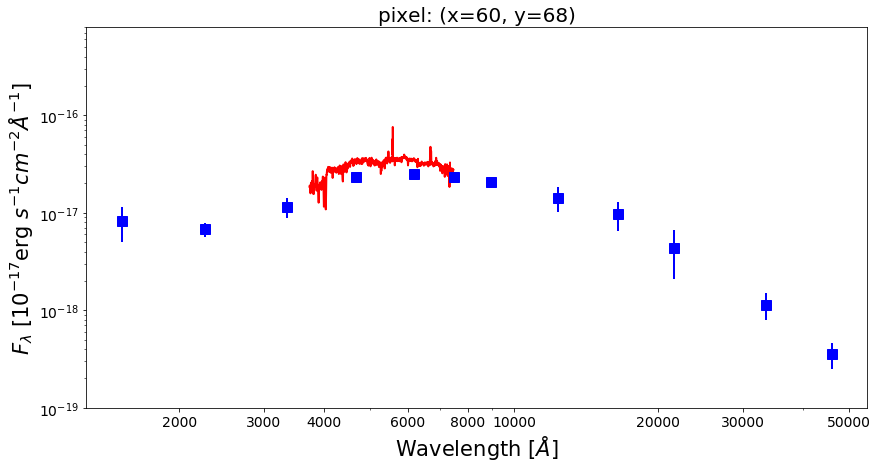

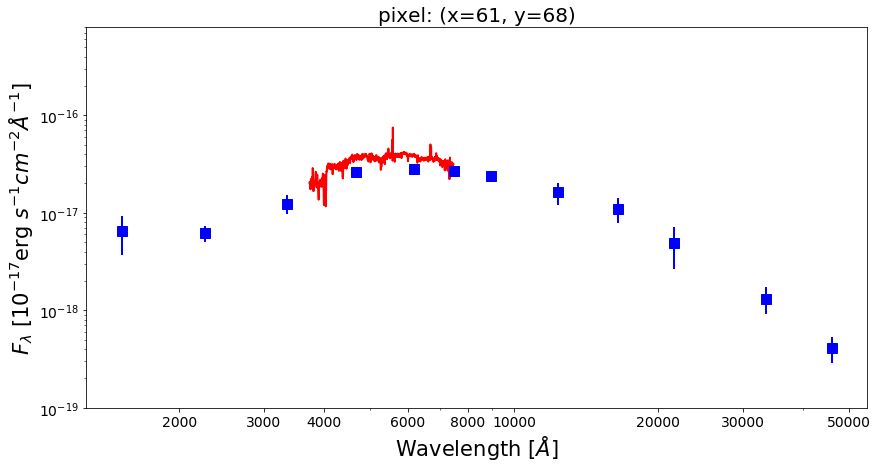

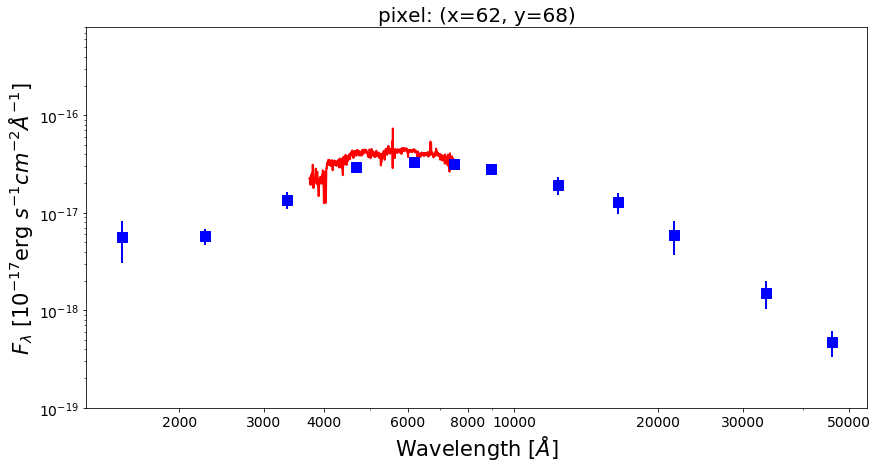

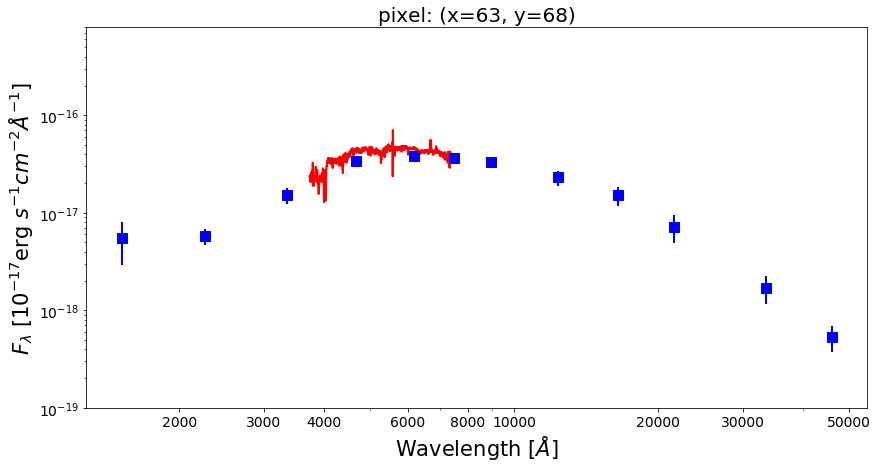

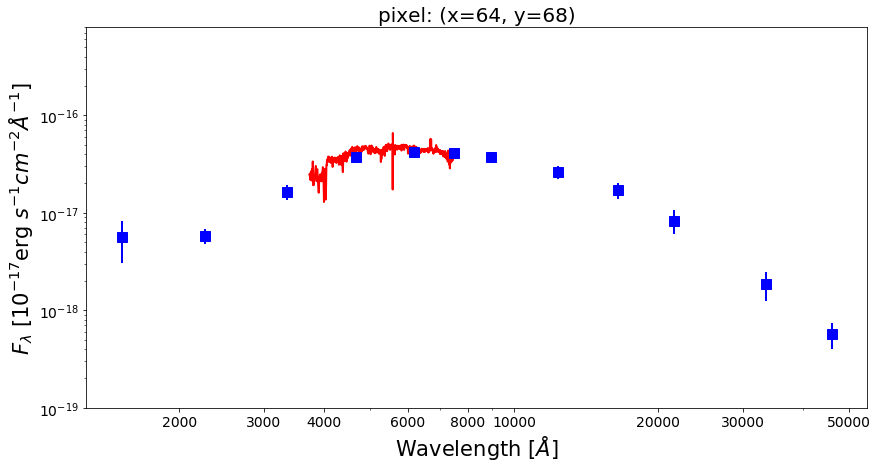

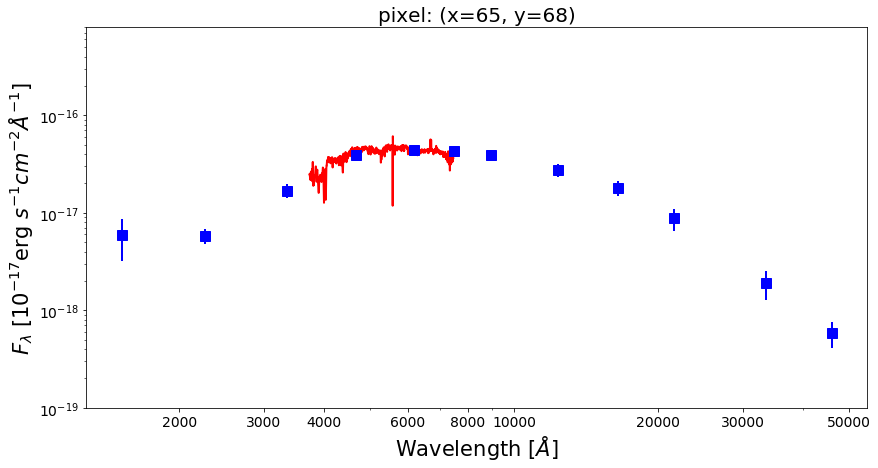

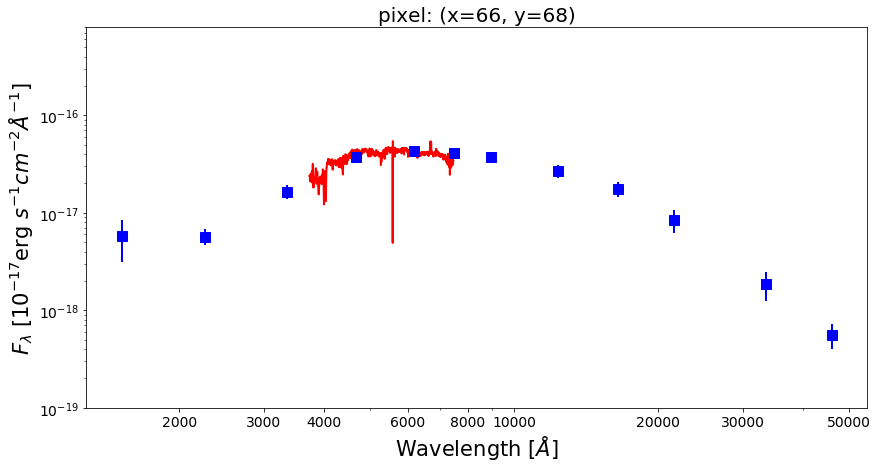

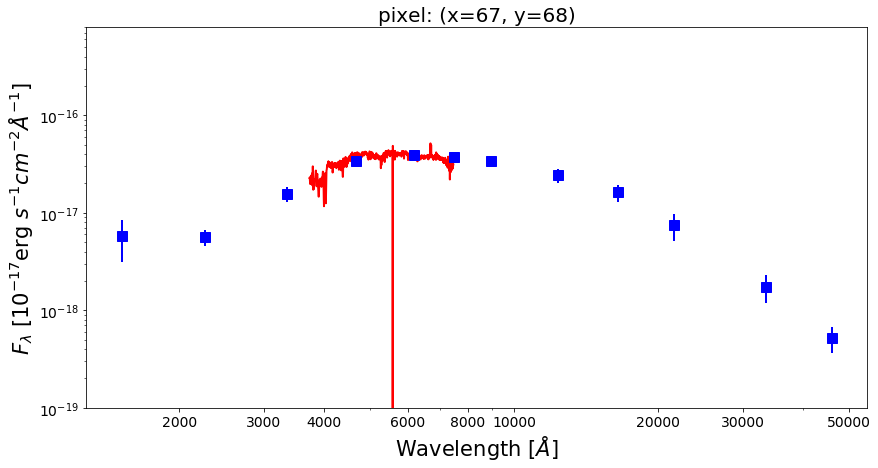

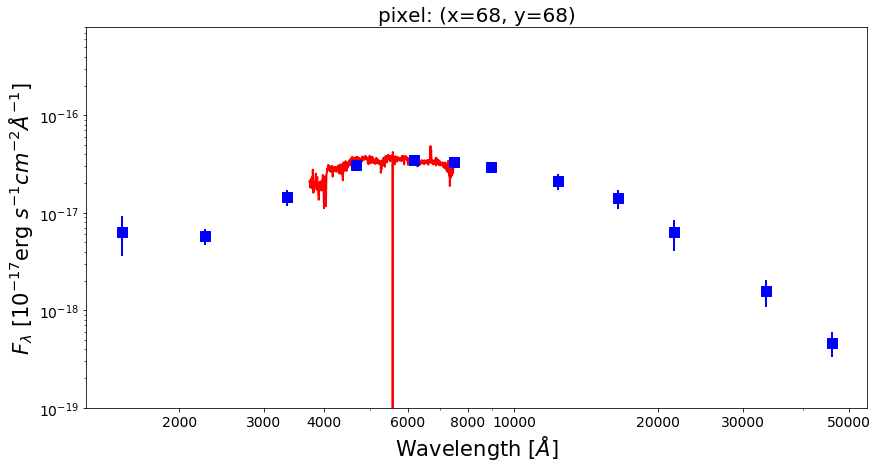

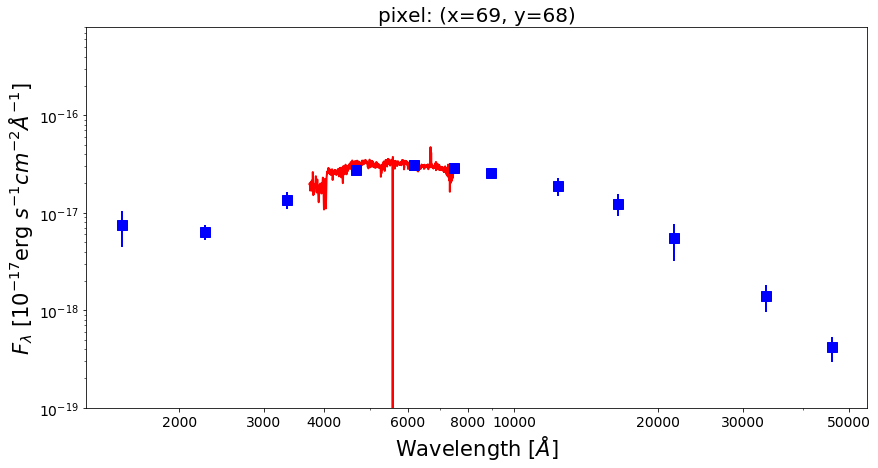

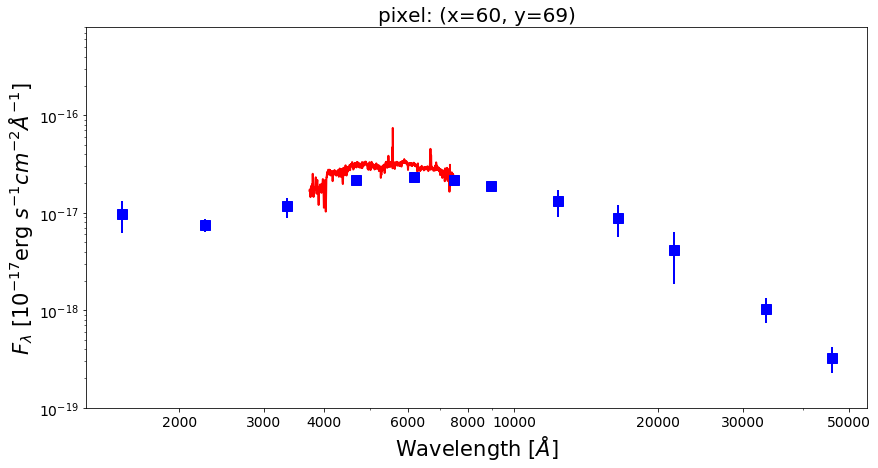

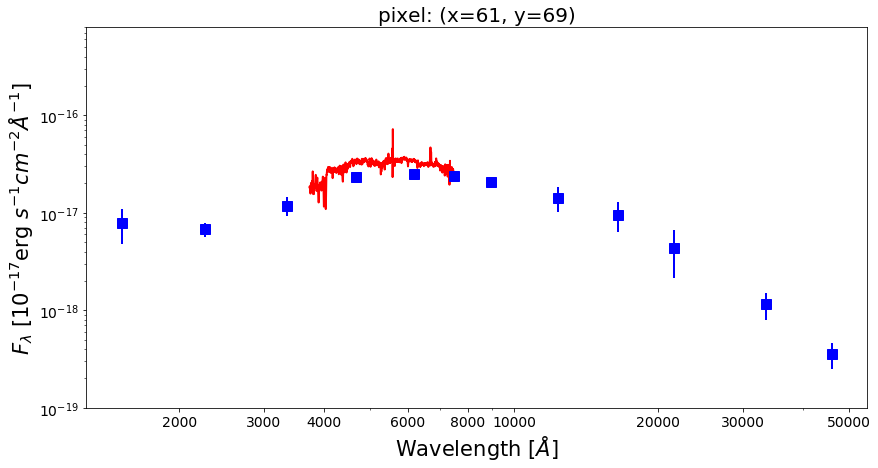

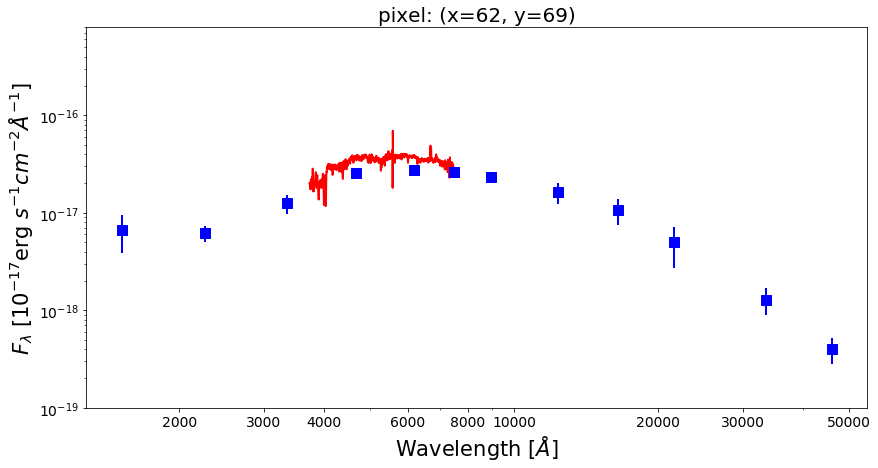

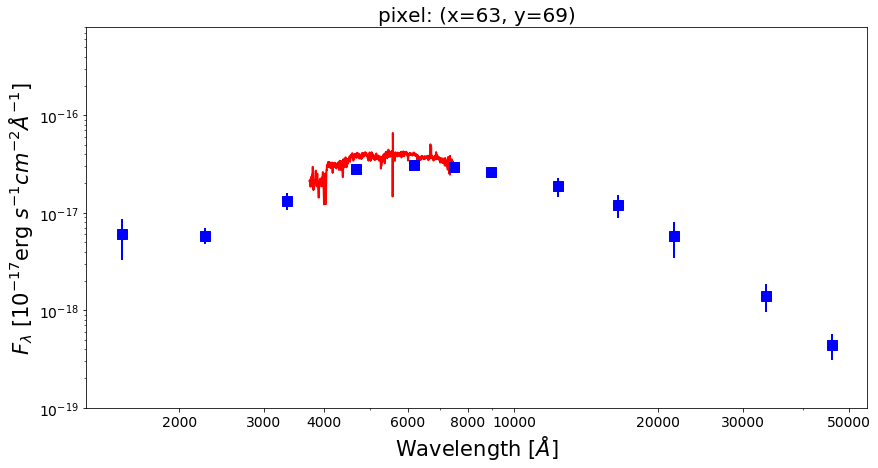

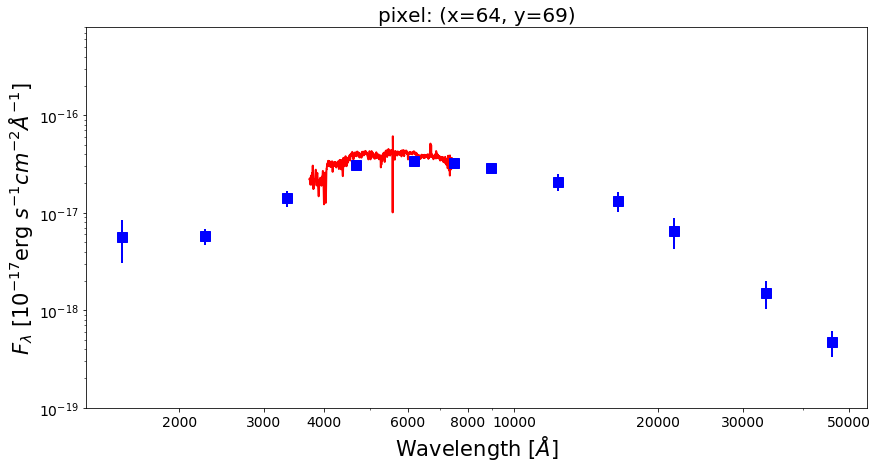

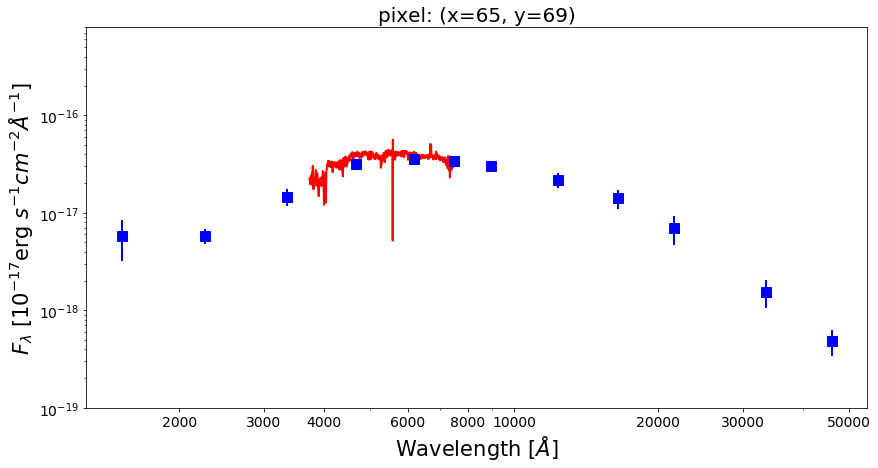

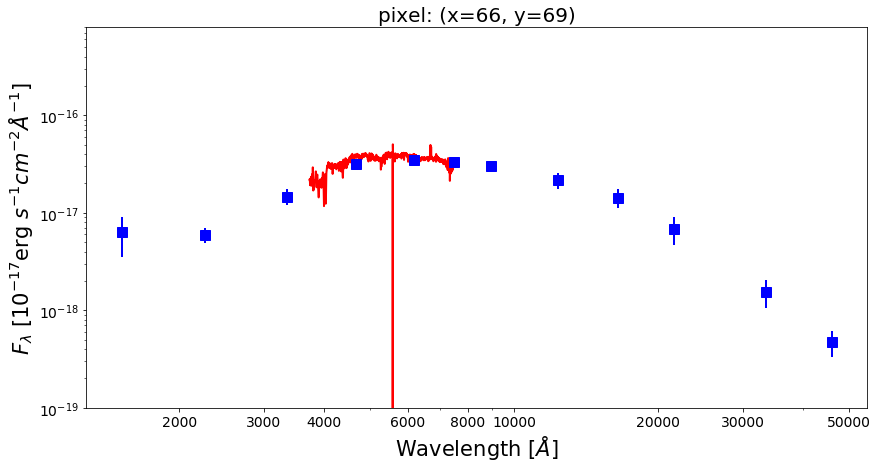

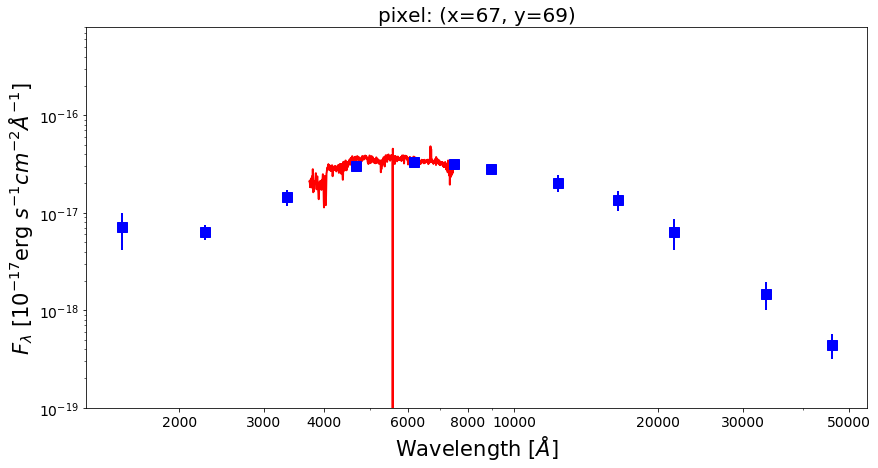

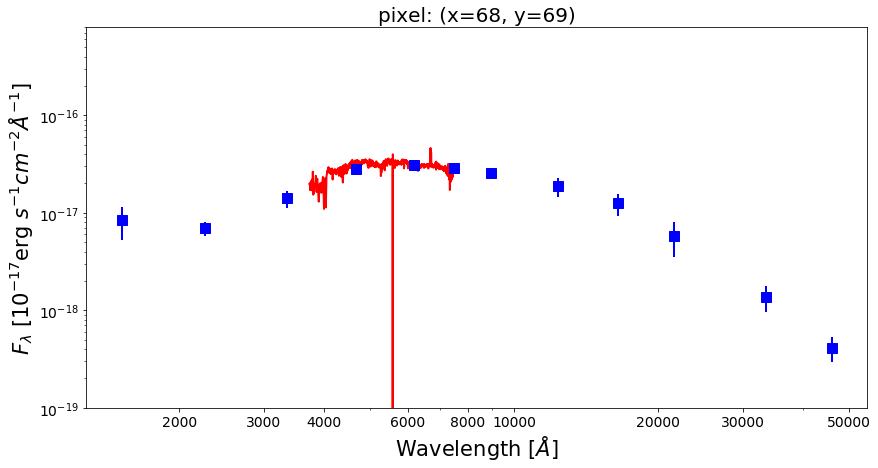

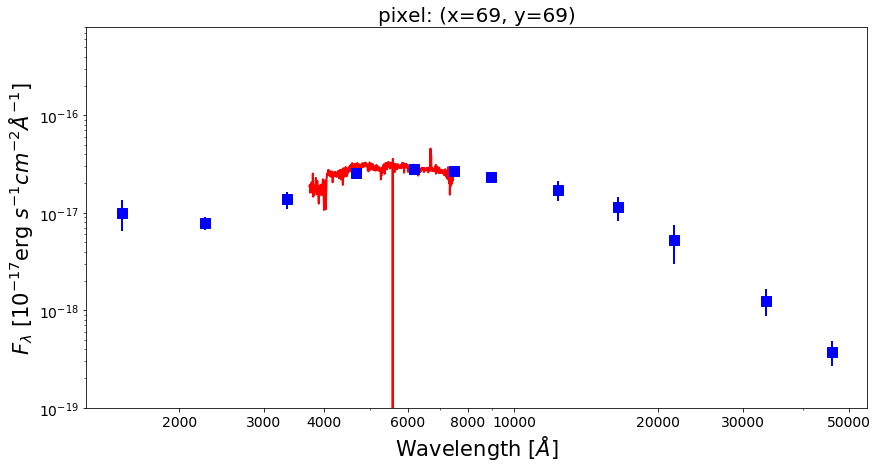

In [9]:
from matplotlib.ticker import ScalarFormatter

nwaves = len(spec_wave)

for yy in range(60,70):
    for xx in range(60,70):
        photo_SED = pix_photo_flux[yy][xx]
        photo_SED_err = pix_photo_flux_err[yy][xx]
        spec_SED = pix_spec_flux[yy][xx]
        spec_SED_err = pix_spec_flux_err[yy][xx]

        fig1 = plt.figure(figsize=(14,7))
        f1 = plt.subplot()   
        plt.title("pixel: (x=%d, y=%d)" % (xx,yy), fontsize=20)
        f1.set_yscale('log')
        f1.set_xscale('log')
        plt.setp(f1.get_yticklabels(), fontsize=14)
        plt.setp(f1.get_xticklabels(), fontsize=14)
        plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
        plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
        xticks = [2000,3000,4000,6000,8000,10000,20000,30000,50000]
        plt.xticks(xticks)
        plt.ylim(1.0e-19,8e-16)
        for axis in [f1.xaxis]:
            axis.set_major_formatter(ScalarFormatter())

        # Optional: cut the spectra around the edges
        plt.plot(spec_wave[20:nwaves-20], spec_SED[20:nwaves-20], lw=2.0, color='red')
        plt.errorbar(photo_wave, photo_SED, yerr=photo_SED_err, markersize=10,
                                color='blue', fmt='s', lw=2)